In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


import plotly.graph_objects as go
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
df = pd.read_csv(r"C:\Users\user\OneDrive\Desktop\python\US_Accidents_Dec20.csv")
print(df)

                ID    Source    TMC  Severity           Start_Time  \
0              A-1  MapQuest  201.0         3  2016-02-08 05:46:00   
1              A-2  MapQuest  201.0         2  2016-02-08 06:07:59   
2              A-3  MapQuest  201.0         2  2016-02-08 06:49:27   
3              A-4  MapQuest  201.0         3  2016-02-08 07:23:34   
4              A-5  MapQuest  201.0         2  2016-02-08 07:39:07   
...            ...       ...    ...       ...                  ...   
4229389  A-4239402      Bing    NaN         2  2019-08-23 18:03:25   
4229390  A-4239403      Bing    NaN         2  2019-08-23 19:11:30   
4229391  A-4239404      Bing    NaN         2  2019-08-23 19:00:21   
4229392  A-4239405      Bing    NaN         2  2019-08-23 19:00:21   
4229393  A-4239406      Bing    NaN         2  2019-08-23 18:52:06   

                    End_Time  Start_Lat   Start_Lng   End_Lat    End_Lng  ...  \
0        2016-02-08 11:00:00  39.865147  -84.058723       NaN        NaN  ... 

In [3]:
print(df.columns)

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [4]:
state_counts = df["State"].value_counts()
fig = go.Figure(data=go.Choropleth(locations=state_counts.index, z=state_counts.values.astype(float), locationmode="USA-states", colorscale="turbo"))
fig.update_layout(title_text="Number of US Accidents for each State", geo_scope="usa")
fig.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



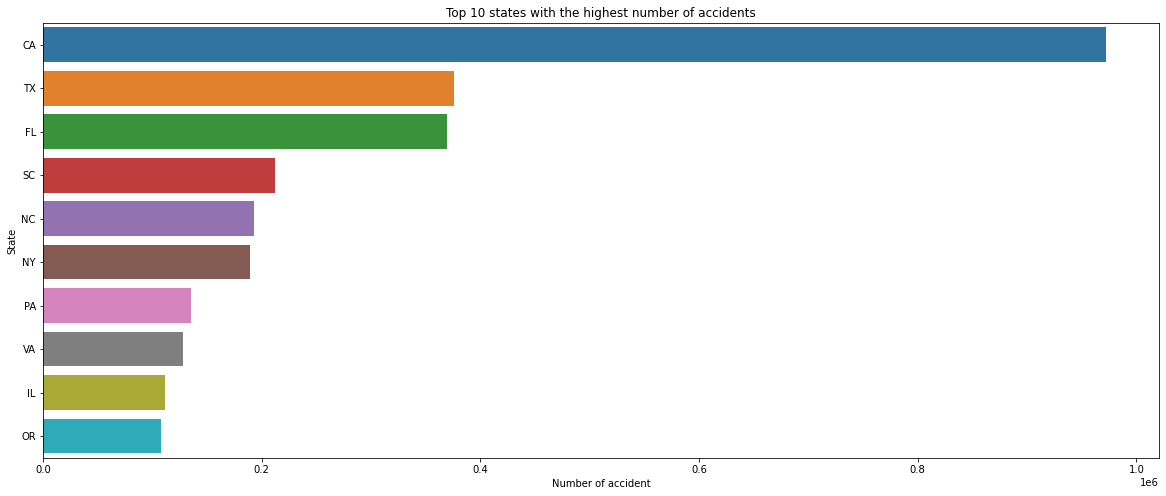

In [5]:
plt.figure(figsize=(20, 8))
plt.title("Top 10 states with the highest number of accidents")
sns.barplot(state_counts[:10].values, state_counts[:10].index, orient="h")
plt.xlabel("Number of accident")
plt.ylabel("State")
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



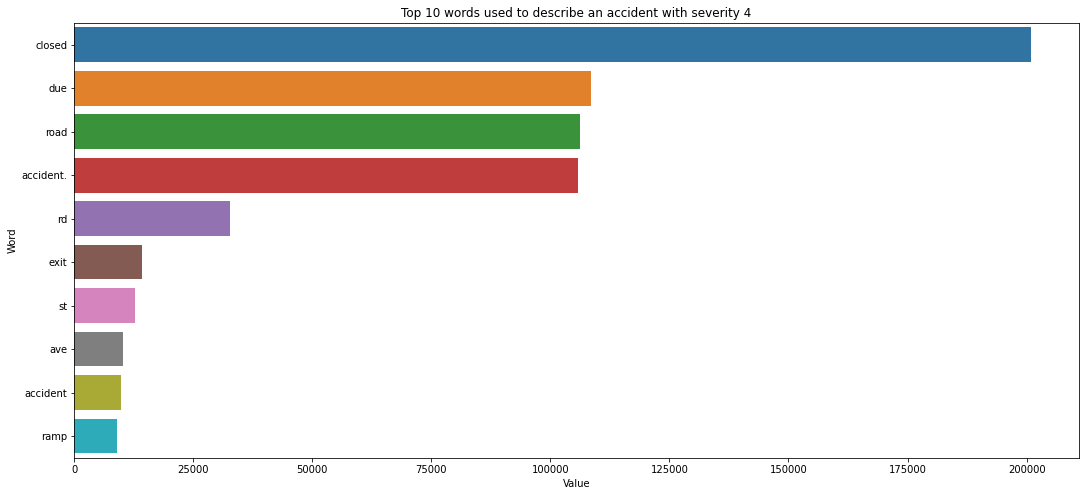

In [6]:
stop = stopwords.words("english") + ["-"]

df_s4_desc = df[df["Severity"] == 4]["Description"]
# Split the description
df_words = df_s4_desc.str.lower().str.split(expand=True).stack()

# If the word is not in the stopwords list
counts = df_words[~df_words.isin(stop)].value_counts()[:10]

plt.figure(figsize=(18, 8))
plt.title("Top 10 words used to describe an accident with severity 4")
sns.barplot(counts.values, counts.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Word")
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



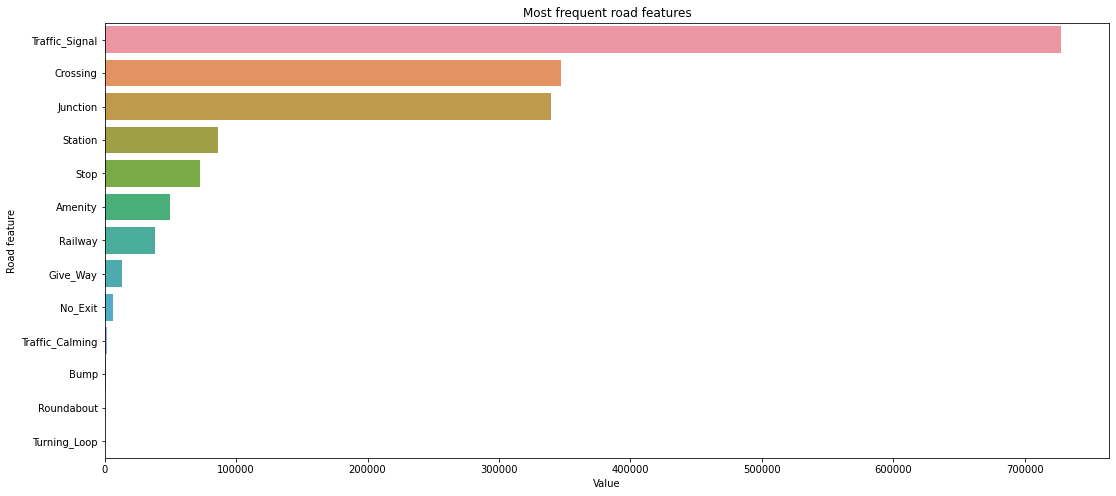

In [7]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
data = df[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Most frequent road features")
sns.barplot(data.values, data.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Road feature")
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



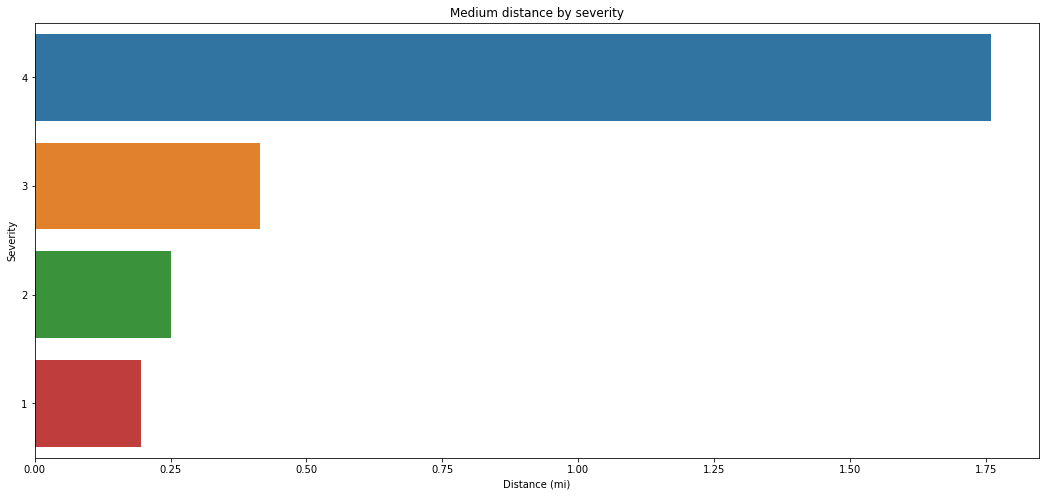

In [8]:
severity_distance = df.groupby("Severity").mean()["Distance(mi)"].sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Medium distance by severity")
sns.barplot(severity_distance.values, severity_distance.index, orient="h", order=severity_distance.index)
plt.xlabel("Distance (mi)")
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



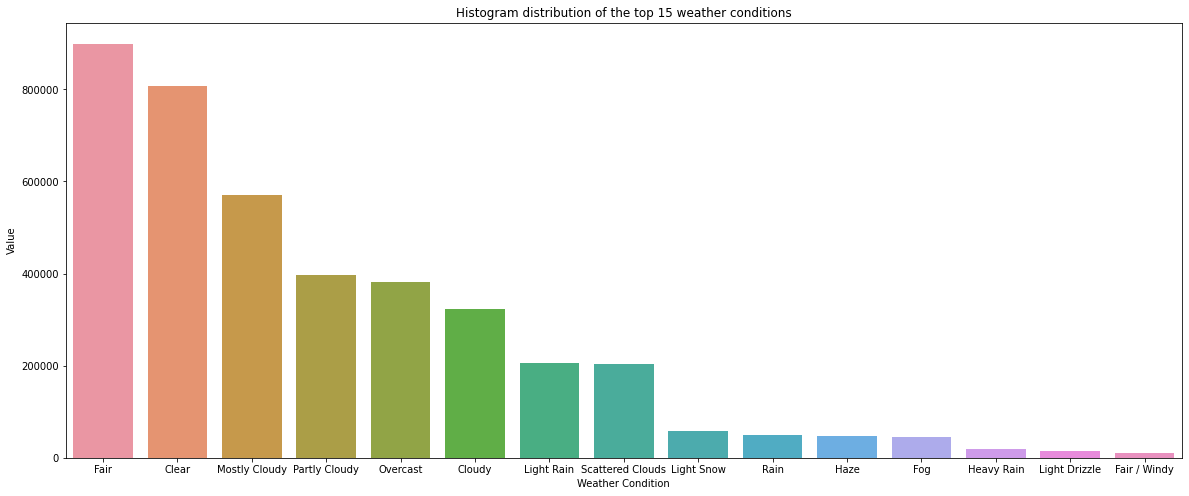

In [9]:
counts = df["Weather_Condition"].value_counts()[:15]
plt.figure(figsize=(20, 8))
plt.title("Histogram distribution of the top 15 weather conditions")
sns.barplot(counts.index, counts.values)
plt.xlabel("Weather Condition")
plt.ylabel("Value")
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



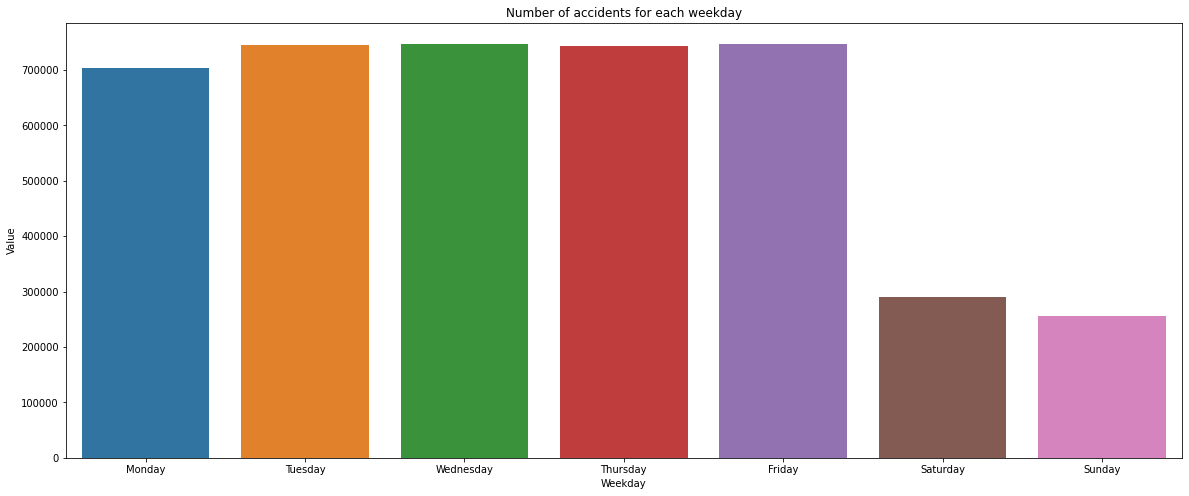

In [10]:
counts = pd.to_datetime(df['Start_Time']).dt.day_name().value_counts()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(20, 8))
plt.title("Number of accidents for each weekday")
sns.barplot(counts.index, counts.values, order=weekdays)
plt.xlabel("Weekday")
plt.ylabel("Value")
plt.show()

In [11]:
X = df
X.head()

ID    Source    TMC  Severity           Start_Time             End_Time  \
0  A-1  MapQuest  201.0         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  MapQuest  201.0         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  MapQuest  201.0         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  MapQuest  201.0         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  MapQuest  201.0         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  ...  Roundabout Station   Stop  \
0  39.865147 -84.058723      NaN      NaN  ...       False   False  False   
1  39.928059 -82.831184      NaN      NaN  ...       False   False  False   
2  39.063148 -84.032608      NaN      NaN  ...       False   False  False   
3  39.747753 -84.205582      NaN      NaN  ...       False   False  False   
4  39.627781 -84.188354      NaN      NaN  ...       False   False  False   

  Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset Civil_Twilight  \
0           False          False        False          Night          Night   
1           False          False        False          Night          Night   
2           False           True        False          Night          Night   
3           False          False        False          Night            Day   
4           False           True        False            Day            Day   

  Nautical_Twilight Astronomical_Twilight  
0             Night                 Night  
1             Night                   Day  
2               Day                   Day  
3               Day                   Day  
4               Day                   Day  

[5 rows x 49 columns]

In [12]:
# Cast Start_Time to datetime
X["Start_Time"] = pd.to_datetime(X["Start_Time"])

# Extract year, month, weekday and day
X["Year"] = X["Start_Time"].dt.year
X["Month"] = X["Start_Time"].dt.month
X["Weekday"] = X["Start_Time"].dt.weekday
X["Day"] = X["Start_Time"].dt.day

# Extract hour and minute
X["Hour"] = X["Start_Time"].dt.hour
X["Minute"] = X["Start_Time"].dt.minute

X.head()

ID    Source    TMC  Severity          Start_Time             End_Time  \
0  A-1  MapQuest  201.0         3 2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  MapQuest  201.0         2 2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  MapQuest  201.0         2 2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  MapQuest  201.0         3 2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  MapQuest  201.0         2 2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  ...  Sunrise_Sunset Civil_Twilight  \
0  39.865147 -84.058723      NaN      NaN  ...           Night          Night   
1  39.928059 -82.831184      NaN      NaN  ...           Night          Night   
2  39.063148 -84.032608      NaN      NaN  ...           Night          Night   
3  39.747753 -84.205582      NaN      NaN  ...           Night            Day   
4  39.627781 -84.188354      NaN      NaN  ...             Day            Day   

   Nautical_Twilight Astronomical_Twilight  Year Month Weekday Day Hour Minute  
0              Night                 Night  2016     2       0   8    5     46  
1              Night                   Day  2016     2       0   8    6      7  
2                Day                   Day  2016     2       0   8    6     49  
3                Day                   Day  2016     2       0   8    7     23  
4                Day                   Day  2016     2       0   8    7     39  

[5 rows x 55 columns]

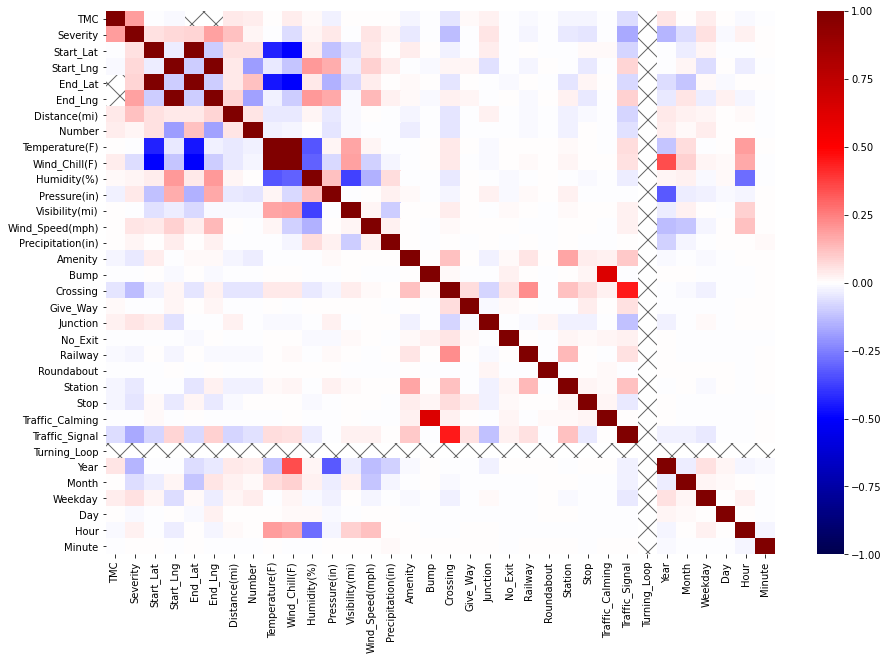

In [13]:
corr_matrix = X.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

In [14]:
features_to_drop = ["ID", "Source", "TMC", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Number", "Street", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
X = X.drop(features_to_drop, axis=1)
X.head()

Severity  Start_Lat  Start_Lng  Distance(mi) Side          City  \
0         3  39.865147 -84.058723          0.01    R        Dayton   
1         2  39.928059 -82.831184          0.01    L  Reynoldsburg   
2         2  39.063148 -84.032608          0.01    R  Williamsburg   
3         3  39.747753 -84.205582          0.01    R        Dayton   
4         2  39.627781 -84.188354          0.01    R        Dayton   

   Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  ...   Stop  \
0            36.9         91.0         29.68            10.0  ...  False   
1            37.9        100.0         29.65            10.0  ...  False   
2            36.0        100.0         29.67            10.0  ...  False   
3            35.1         96.0         29.64             9.0  ...  False   
4            36.0         89.0         29.65             6.0  ...  False   

   Traffic_Calming  Traffic_Signal Civil_Twilight  Year  Month  Weekday  Day  \
0            False           False          Night  2016      2        0    8   
1            False           False          Night  2016      2        0    8   
2            False            True          Night  2016      2        0    8   
3            False           False            Day  2016      2        0    8   
4            False            True            Day  2016      2        0    8   

   Hour  Minute  
0     5      46  
1     6       7  
2     6      49  
3     7      23  
4     7      39  

[5 rows x 33 columns]

In [15]:
print("Number of rows:", len(X.index))
X.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(X.index))

Number of rows: 4229394
Number of rows after drop of duplicates: 4053945


In [16]:
X["Side"].value_counts()

R    3321277
L     732667
           1
Name: Side, dtype: int64

In [18]:
X = X[X["Side"] != " "]
X["Side"].value_counts()

R    3321277
L     732667
Name: Side, dtype: int64

In [19]:
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

Pressure(in)  Visibility(mi)
count    3982555.00      3961162.00
mean          29.70            9.11
std            0.86            2.83
min            0.00            0.00
25%           29.65           10.00
50%           29.93           10.00
75%           30.08           10.00
max           58.04          140.00

In [20]:
X = X[X["Pressure(in)"] != 0]
X = X[X["Visibility(mi)"] != 0]
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

Pressure(in)  Visibility(mi)
count    3980161.00      3958766.00
mean          29.70            9.12
std            0.85            2.82
min            0.02            0.06
25%           29.65           10.00
50%           29.93           10.00
75%           30.08           10.00
max           58.04          140.00

In [21]:
unique_weather = X["Weather_Condition"].unique()

print(len(unique_weather))
print(unique_weather)

132
['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Light Fog' 'Sand'
 'Sn

In [22]:
X.loc[X["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
X.loc[X["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
X.loc[X["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
X.loc[X["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
X.loc[X["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
X.loc[X["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
X.loc[X["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
X.loc[X["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
X.loc[X["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
X.loc[X["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
X.loc[X["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(X["Weather_Condition"].unique())

['Rain' 'Cloudy' 'Snow' 'Fog' 'Clear' nan 'Smoke' 'Thunderstorm' 'Sand'
 'Windy' 'Hail' 'Tornado']


In [23]:
X["Wind_Direction"].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [24]:
X.loc[X["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
X.loc[X["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
X.loc[X["Wind_Direction"] == "East", "Wind_Direction"] = "E"
X.loc[X["Wind_Direction"] == "North", "Wind_Direction"] = "N"
X.loc[X["Wind_Direction"] == "South", "Wind_Direction"] = "S"
X.loc[X["Wind_Direction"] == "West", "Wind_Direction"] = "W"

X["Wind_Direction"] = X["Wind_Direction"].map(lambda x : x if len(x) != 3 else x[1:], na_action="ignore")

X["Wind_Direction"].unique()

array(['Calm', 'SW', 'NW', 'W', 'NE', 'S', 'N', 'Variable', 'SE', 'E',
       nan], dtype=object)

In [25]:
X.isna().sum()

Severity                   0
Start_Lat                  0
Start_Lng                  0
Distance(mi)               0
Side                       0
City                     131
Temperature(F)         83921
Humidity(%)            89072
Pressure(in)           71386
Visibility(mi)         92781
Wind_Direction         77246
Wind_Speed(mph)       471067
Precipitation(in)    2045417
Weather_Condition      93214
Amenity                    0
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0
No_Exit                    0
Railway                    0
Roundabout                 0
Station                    0
Stop                       0
Traffic_Calming            0
Traffic_Signal             0
Civil_Twilight           135
Year                       0
Month                      0
Weekday                    0
Day                        0
Hour                       0
Minute                     0
dtype: int64

In [26]:
features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
X[features_to_fill] = X[features_to_fill].fillna(X[features_to_fill].mean())

X.dropna(inplace=True)

X.isna().sum()

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Side                 0
City                 0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Civil_Twilight       0
Year                 0
Month                0
Weekday              0
Day                  0
Hour                 0
Minute               0
dtype: int64

In [27]:
X.describe().round(2)

Severity   Start_Lat   Start_Lng  Distance(mi)  Temperature(F)  \
count  3945422.00  3945422.00  3945422.00    3945422.00      3945422.00   
mean         2.31       36.40      -95.54          0.32           61.69   
std          0.54        4.96       17.29          1.59           18.49   
min          1.00       24.56     -124.62          0.00          -89.00   
25%          2.00       33.52     -117.36          0.00           50.00   
50%          2.00       35.80      -90.08          0.00           63.00   
75%          3.00       40.21      -80.91          0.05           75.20   
max          4.00       49.00      -67.11        441.75          189.00   

       Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
count   3945422.00    3945422.00      3945422.00       3945422.00   
mean         65.63         29.70            9.12             7.95   
std          22.66          0.85            2.82             5.05   
min           1.00          0.02            0.06             0.00   
25%          49.00         29.65           10.00             5.00   
50%          68.00         29.93           10.00             7.95   
75%          85.00         30.08           10.00            10.40   
max         100.00         58.04          140.00           984.00   

       Precipitation(in)        Year       Month     Weekday         Day  \
count         3945422.00  3945422.00  3945422.00  3945422.00  3945422.00   
mean                0.01     2018.39        7.08        2.45       15.85   
std                 0.11        1.32        3.55        1.75        8.70   
min                 0.00     2016.00        1.00        0.00        1.00   
25%                 0.00     2017.00        4.00        1.00        8.00   
50%                 0.01     2019.00        8.00        2.00       16.00   
75%                 0.01     2020.00       10.00        4.00       23.00   
max                25.00     2020.00       12.00        6.00       31.00   

             Hour      Minute  
count  3945422.00  3945422.00  
mean        12.13       29.98  
std          5.38       17.29  
min          0.00        0.00  
25%          8.00       15.00  
50%         12.00       30.00  
75%         17.00       45.00  
max         23.00       59.00

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



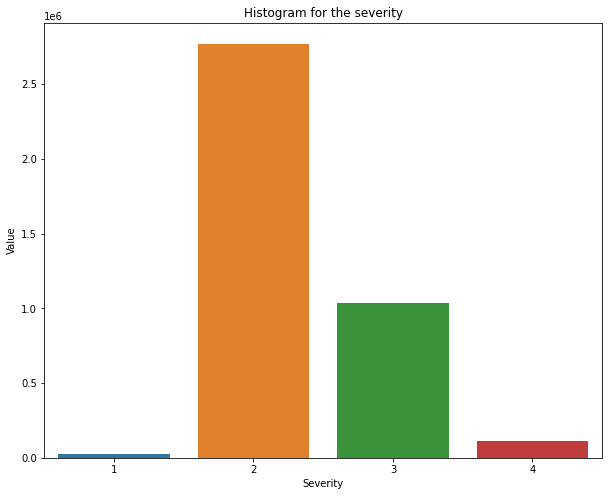

In [28]:
severity_counts = X["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [29]:
size = len(X[X["Severity"]==1].index)
df = pd.DataFrame()
for i in range(1,5):
    S = X[X["Severity"]==i]
    df = df.append(S.sample(size, random_state=42))
X = df

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



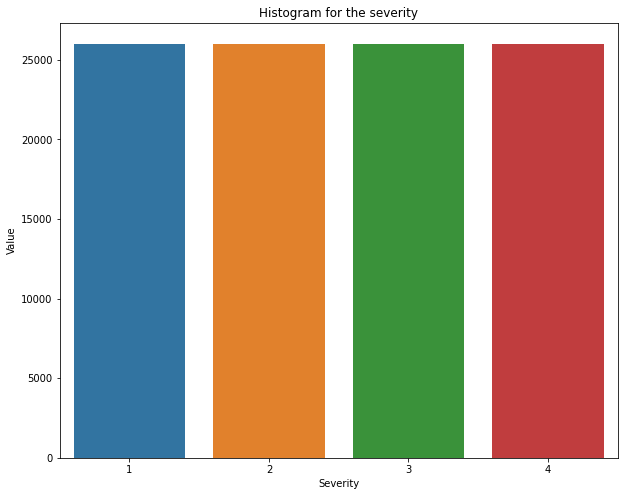

In [30]:
severity_counts = X["Severity"].value_counts()
plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [31]:
scaler = MinMaxScaler()
features = ['Temperature(F)','Distance(mi)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Start_Lng','Start_Lat','Year', 'Month','Weekday','Day','Hour','Minute']
X[features] = scaler.fit_transform(X[features])
X.head()

Severity  Start_Lat  Start_Lng  Distance(mi) Side        City  \
3606841         1   0.470536   0.790681      0.000033    R  Burlington   
3607845         1   0.536949   0.042155      0.000000    R     Hayward   
3581469         1   0.459056   0.804617      0.000000    R     Raleigh   
3490088         1   0.707374   0.642000      0.000000    L  Villa Park   
3458899         1   0.537486   0.046574      0.000000    R  Pleasanton   

         Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  ...  \
3606841           0.505     0.091837      0.935288        0.124343  ...   
3607845           0.375     0.734694      0.966750        0.124343  ...   
3581469           0.490     0.561224      0.956024        0.124343  ...   
3490088           0.415     0.867347      0.932070        0.111834  ...   
3458899           0.420     0.500000      0.952092        0.124343  ...   

          Stop  Traffic_Calming  Traffic_Signal Civil_Twilight  Year  \
3606841  False            False           False            Day   1.0   
3607845  False            False            True          Night   1.0   
3581469  False            False            True            Day   1.0   
3490088  False            False            True            Day   1.0   
3458899  False            False           False          Night   1.0   

            Month   Weekday       Day      Hour    Minute  
3606841  0.272727  0.666667  0.066667  0.782609  0.169492  
3607845  0.272727  0.500000  0.033333  1.000000  0.440678  
3581469  0.181818  0.833333  0.666667  0.652174  0.932203  
3490088  0.363636  0.000000  0.566667  0.739130  1.000000  
3458899  0.272727  0.500000  0.966667  0.913043  0.067797  

[5 rows x 33 columns]

In [32]:
categorical_features = set(["Side", "City", "Wind_Direction", "Weather_Condition", "Civil_Twilight"])

for cat in categorical_features:
    X[cat] = X[cat].astype("category")

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104036 entries, 3606841 to 2826074
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Severity           104036 non-null  int64   
 1   Start_Lat          104036 non-null  float64 
 2   Start_Lng          104036 non-null  float64 
 3   Distance(mi)       104036 non-null  float64 
 4   Side               104036 non-null  category
 5   City               104036 non-null  category
 6   Temperature(F)     104036 non-null  float64 
 7   Humidity(%)        104036 non-null  float64 
 8   Pressure(in)       104036 non-null  float64 
 9   Visibility(mi)     104036 non-null  float64 
 10  Wind_Direction     104036 non-null  category
 11  Wind_Speed(mph)    104036 non-null  float64 
 12  Precipitation(in)  104036 non-null  float64 
 13  Weather_Condition  104036 non-null  category
 14  Amenity            104036 non-null  bool    
 15  Bump               104036 n

In [33]:
print("Unique classes for each categorical feature:")
for cat in categorical_features:
    print("{:15s}".format(cat), "\t", len(X[cat].unique()))

Unique classes for each categorical feature:
Civil_Twilight  	 2
Wind_Direction  	 10
Weather_Condition 	 10
City            	 6719
Side            	 2


In [34]:
X = X.replace([True, False], [1, 0])

X.head()


Severity  Start_Lat  Start_Lng  Distance(mi) Side        City  \
3606841         1   0.470536   0.790681      0.000033    R  Burlington   
3607845         1   0.536949   0.042155      0.000000    R     Hayward   
3581469         1   0.459056   0.804617      0.000000    R     Raleigh   
3490088         1   0.707374   0.642000      0.000000    L  Villa Park   
3458899         1   0.537486   0.046574      0.000000    R  Pleasanton   

         Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  ... Stop  \
3606841           0.505     0.091837      0.935288        0.124343  ...    0   
3607845           0.375     0.734694      0.966750        0.124343  ...    0   
3581469           0.490     0.561224      0.956024        0.124343  ...    0   
3490088           0.415     0.867347      0.932070        0.111834  ...    0   
3458899           0.420     0.500000      0.952092        0.124343  ...    0   

         Traffic_Calming  Traffic_Signal Civil_Twilight  Year     Month  \
3606841                0               0            Day   1.0  0.272727   
3607845                0               1          Night   1.0  0.272727   
3581469                0               1            Day   1.0  0.181818   
3490088                0               1            Day   1.0  0.363636   
3458899                0               0          Night   1.0  0.272727   

          Weekday       Day      Hour    Minute  
3606841  0.666667  0.066667  0.782609  0.169492  
3607845  0.500000  0.033333  1.000000  0.440678  
3581469  0.833333  0.666667  0.652174  0.932203  
3490088  0.000000  0.566667  0.739130  1.000000  
3458899  0.500000  0.966667  0.913043  0.067797  

[5 rows x 33 columns]

In [35]:
# Remove city because it will be encoded later
onehot_cols = categorical_features - set(["City"])

X = pd.get_dummies(X, columns=onehot_cols, drop_first=True)

X.head()

Severity  Start_Lat  Start_Lng  Distance(mi)        City  \
3606841         1   0.470536   0.790681      0.000033  Burlington   
3607845         1   0.536949   0.042155      0.000000     Hayward   
3581469         1   0.459056   0.804617      0.000000     Raleigh   
3490088         1   0.707374   0.642000      0.000000  Villa Park   
3458899         1   0.537486   0.046574      0.000000  Pleasanton   

         Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
3606841           0.505     0.091837      0.935288        0.124343   
3607845           0.375     0.734694      0.966750        0.124343   
3581469           0.490     0.561224      0.956024        0.124343   
3490088           0.415     0.867347      0.932070        0.111834   
3458899           0.420     0.500000      0.952092        0.124343   

         Wind_Speed(mph)  ...  Side_R  Wind_Direction_E  Wind_Direction_N  \
3606841         0.060345  ...       1                 0                 0   
3607845         0.012931  ...       1                 0                 0   
3581469         0.038793  ...       1                 0                 0   
3490088         0.056034  ...       0                 0                 0   
3458899         0.021552  ...       1                 0                 0   

         Wind_Direction_NE  Wind_Direction_NW  Wind_Direction_S  \
3606841                  0                  1                 0   
3607845                  0                  0                 0   
3581469                  1                  0                 0   
3490088                  1                  0                 0   
3458899                  0                  0                 0   

         Wind_Direction_SE  Wind_Direction_SW  Wind_Direction_Variable  \
3606841                  0                  0                        0   
3607845                  1                  0                        0   
3581469                  0                  0                        0   
3490088                  0                  0                        0   
3458899                  0                  1                        0   

         Wind_Direction_W  
3606841                 0  
3607845                 0  
3581469                 0  
3490088                 0  
3458899                 0  

[5 rows x 49 columns]

In [36]:
binary_encoder = ce.binary.BinaryEncoder()

city_binary_enc = binary_encoder.fit_transform(X["City"])
city_binary_enc

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



City_0  City_1  City_2  City_3  City_4  City_5  City_6  City_7  \
3606841       0       0       0       0       0       0       0       0   
3607845       0       0       0       0       0       0       0       0   
3581469       0       0       0       0       0       0       0       0   
3490088       0       0       0       0       0       0       0       0   
3458899       0       0       0       0       0       0       0       0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
4177315       0       0       0       1       1       1       0       0   
4117971       0       0       0       0       1       0       1       1   
3912294       0       0       0       0       0       0       1       1   
2865254       0       0       0       1       1       0       0       1   
2826074       0       1       1       0       1       0       0       0   

         City_8  City_9  City_10  City_11  City_12  City_13  
3606841       0       0        0        0        0        1  
3607845       0       0        0        0        1        0  
3581469       0       0        0        0        1        1  
3490088       0       0        0        1        0        0  
3458899       0       0        0        1        0        1  
...         ...     ...      ...      ...      ...      ...  
4177315       0       1        1        0        1        0  
4117971       0       0        1        0        0        0  
3912294       1       1        0        1        1        1  
2865254       1       0        1        0        1        0  
2826074       1       1        1        1        1        1  

[104036 rows x 14 columns]

In [37]:
X = pd.concat([X, city_binary_enc], axis=1).drop("City", axis=1)

X.head()

Severity  Start_Lat  Start_Lng  Distance(mi)  Temperature(F)  \
3606841         1   0.470536   0.790681      0.000033           0.505   
3607845         1   0.536949   0.042155      0.000000           0.375   
3581469         1   0.459056   0.804617      0.000000           0.490   
3490088         1   0.707374   0.642000      0.000000           0.415   
3458899         1   0.537486   0.046574      0.000000           0.420   

         Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
3606841     0.091837      0.935288        0.124343         0.060345   
3607845     0.734694      0.966750        0.124343         0.012931   
3581469     0.561224      0.956024        0.124343         0.038793   
3490088     0.867347      0.932070        0.111834         0.056034   
3458899     0.500000      0.952092        0.124343         0.021552   

         Precipitation(in)  ...  City_4  City_5  City_6  City_7  City_8  \
3606841                0.0  ...       0       0       0       0       0   
3607845                0.0  ...       0       0       0       0       0   
3581469                0.0  ...       0       0       0       0       0   
3490088                0.0  ...       0       0       0       0       0   
3458899                0.0  ...       0       0       0       0       0   

         City_9  City_10  City_11  City_12  City_13  
3606841       0        0        0        0        1  
3607845       0        0        0        1        0  
3581469       0        0        0        1        1  
3490088       0        0        1        0        0  
3458899       0        0        1        0        1  

[5 rows x 62 columns]

In [38]:
# Metrics dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

In [39]:
# Train/Validation - Test split
X, X_test = train_test_split(X, test_size=.2, random_state=42)
print(X.shape, X_test.shape)

(83228, 62) (20808, 62)


In [40]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62421, 61) (62421,)
(20807, 61) (20807,)


In [41]:
lr = LogisticRegression(random_state=42, n_jobs=-1)
params = {"solver": ["newton-cg", "sag", "saga"]}
grid = GridSearchCV(lr, params, n_jobs=-1, verbose=5)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters scores:
{'solver': 'newton-cg'}
Train score: 0.6191826468656382
Validation score: 0.6148411592252607


In [42]:
print("Default scores:")
lr.fit(X_train, y_train)
print("Train score:", lr.score(X_train, y_train))
print("Validation score:", lr.score(X_validate, y_validate))

Default scores:
Train score: 0.6076160266576953
Validation score: 0.6070553179218532


In [43]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_solver  \
0      31.752462      1.170294         0.011378        0.003718    newton-cg   
1       7.373760      0.661086         0.030488        0.017762          sag   
2      10.624728      0.767888         0.022093        0.004443         saga   

                    params  split0_test_score  split1_test_score  \
0  {'solver': 'newton-cg'}           0.624029           0.615107   
1        {'solver': 'sag'}           0.623548           0.615187   
2       {'solver': 'saga'}           0.624029           0.615107   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.611503           0.612063            0.61735         0.616011   
1           0.611423           0.611903            0.61743         0.615898   
2           0.611503           0.612063            0.61735         0.616011   

   std_test_score  rank_test_score  
0        0.004534                1  
1        0.004413                3  
2        0.004534                1

In [44]:
y_pred = lr.predict(X_validate)

accuracy["Logistic Regression"] = accuracy_score(y_validate, y_pred)
f1["Logistic Regression"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, lr.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.93      0.82     15612
           2       0.56      0.44      0.50     15561
           3       0.50      0.57      0.54     15522
           4       0.61      0.48      0.54     15726

    accuracy                           0.61     62421
   macro avg       0.60      0.61      0.60     62421
weighted avg       0.60      0.61      0.60     62421

              precision    recall  f1-score   support

           1       0.73      0.93      0.82      5220
           2       0.57      0.45      0.50      5173
           3       0.50      0.57      0.53      5264
           4       0.60      0.47      0.53      5150

    accuracy                           0.61     20807
   macro avg       0.60      0.61      0.60     20807
weighted avg       0.60      0.61      0.60     20807



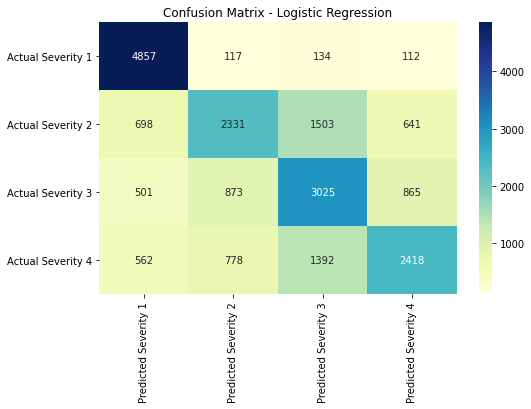

In [45]:
y_pred = lr.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

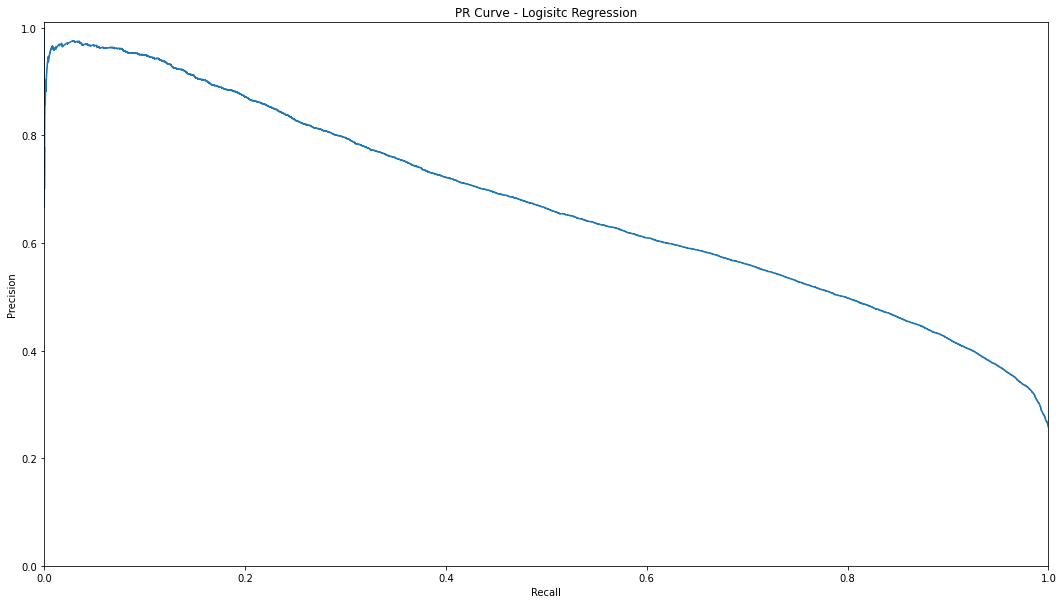

In [46]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = lr.predict_proba(X_validate)

precision["Logistic Regression"], recall["Logistic Regression"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Logistic Regression"], precision["Logistic Regression"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Logisitc Regression")
plt.show()

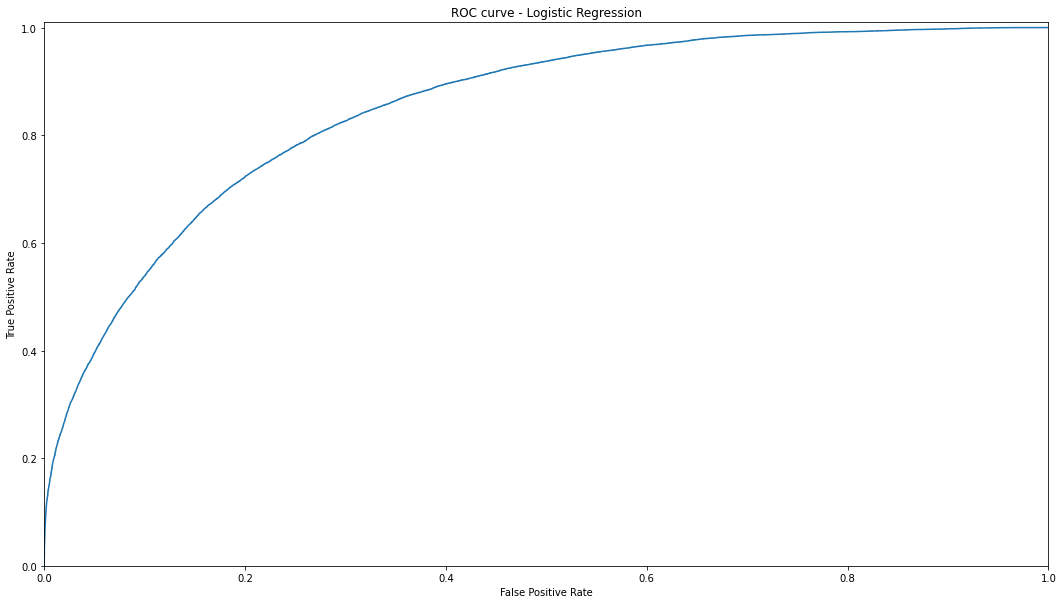

In [47]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Logistic Regression"], tpr["Logistic Regression"], where="post")

plt.title("ROC curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [48]:
parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]
svc = svm.SVC(verbose=5, random_state=42)
grid = GridSearchCV(svc, parameters, verbose=5, n_jobs=-1)

sample = X.sample(5_000, random_state=42)
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)
grid.fit(X_sample, y_sample)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_sample, y_sample))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LibSVM]Best parameters scores:
{'C': 0.5, 'degree': 3, 'kernel': 'poly'}
Train score: 0.716


In [49]:
print("Default scores:")
svc.fit(X_sample, y_sample)
print("Train score:", svc.score(X_sample, y_sample))

Default scores:
[LibSVM]Train score: 0.705


In [50]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
16       3.580527      0.385908         0.773498        0.014752     0.5   
21       5.247238      1.104725         1.468359        0.303631     1.0   
10       4.637834      0.164485         1.218900        0.058089     1.0   
9        3.519360      0.357975         0.646007        0.086570     1.0   
18       3.676221      0.240047         1.054539        0.122292     0.8   
19       4.429258      0.180488         1.036160        0.218478     0.8   
6        3.096346      0.121192         0.633593        0.029144     0.8   
7        4.254145      0.361969         1.137817        0.046541     0.8   
15       3.793278      0.260178         0.761789        0.042145     0.5   
22       7.337637      0.467173         1.093570        0.220475     1.0   
3        2.679127      0.173671         0.601268        0.069600     0.5   
17       4.016202      0.259649         1.048009        0.133843     0.5   
14       4.265000      0.281825         0.825911        0.036987     0.2   
20       6.063611      0.427696         1.555504        0.129200     0.8   
4        4.438146      0.327406         1.147018        0.023933     0.5   
0        3.133638      0.150469         0.721909        0.032135     0.2   
13       4.079153      0.163692         0.833214        0.036535     0.2   
23       7.101612      0.306414         0.400515        0.035785     1.0   
12       3.472787      0.722240         0.902379        0.062915     0.2   
1        5.615781      0.129726         1.613266        0.906040     0.2   
5        4.147765      0.306314         0.825202        0.028794     0.5   
2        4.944352      0.710701         0.730238        0.074144     0.2   
8        4.125722      0.272659         0.725584        0.045342     0.8   
11       4.646263      0.533985         0.831165        0.112363     1.0   

   param_kernel param_degree                                     params  \
16         poly            3  {'C': 0.5, 'degree': 3, 'kernel': 'poly'}   
21         poly            2  {'C': 1.0, 'degree': 2, 'kernel': 'poly'}   
10          rbf          NaN                {'C': 1.0, 'kernel': 'rbf'}   
9        linear          NaN             {'C': 1.0, 'kernel': 'linear'}   
18         poly            2  {'C': 0.8, 'degree': 2, 'kernel': 'poly'}   
19         poly            3  {'C': 0.8, 'degree': 3, 'kernel': 'poly'}   
6        linear          NaN             {'C': 0.8, 'kernel': 'linear'}   
7           rbf          NaN                {'C': 0.8, 'kernel': 'rbf'}   
15         poly            2  {'C': 0.5, 'degree': 2, 'kernel': 'poly'}   
22         poly            3  {'C': 1.0, 'degree': 3, 'kernel': 'poly'}   
3        linear          NaN             {'C': 0.5, 'kernel': 'linear'}   
17         poly            4  {'C': 0.5, 'degree': 4, 'kernel': 'poly'}   
14         poly            4  {'C': 0.2, 'degree': 4, 'kernel': 'poly'}   
20         poly            4  {'C': 0.8, 'degree': 4, 'kernel': 'poly'}   
4           rbf          NaN                {'C': 0.5, 'kernel': 'rbf'}   
0        linear          NaN             {'C': 0.2, 'kernel': 'linear'}   
13         poly            3  {'C': 0.2, 'degree': 3, 'kernel': 'poly'}   
23         poly            4  {'C': 1.0, 'degree': 4, 'kernel': 'poly'}   
12         poly            2  {'C': 0.2, 'degree': 2, 'kernel': 'poly'}   
1           rbf          NaN                {'C': 0.2, 'kernel': 'rbf'}   
5       sigmoid          NaN            {'C': 0.5, 'kernel': 'sigmoid'}   
2       sigmoid          NaN            {'C': 0.2, 'kernel': 'sigmoid'}   
8       sigmoid          NaN            {'C': 0.8, 'kernel': 'sigmoid'}   
11      sigmoid          NaN            {'C': 1.0, 'kernel': 'sigmoid'}   

    split0_test_score  split1_test_score  split2_test_score  \
16              0.565              0.595              0.611   
21              0.571              0.593              0.605   
10              0.574              0.5

In [51]:
sample = X.sample(10_000, random_state=42)
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, test_size=.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(8000, 61) (8000,)
(2000, 61) (2000,)


In [52]:
svc = svm.SVC(**grid.best_params_, random_state=42)
svc.fit(X_train, y_train)

print("Train score:", svc.score(X_train, y_train))
print("Validation score:", svc.score(X_validate, y_validate))

Train score: 0.69425
Validation score: 0.594


In [53]:
y_pred = svc.predict(X_validate)

accuracy["SVM"] = accuracy_score(y_validate, y_pred)
f1["SVM"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, svc.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.96      0.85      2024
           2       0.70      0.55      0.62      1971
           3       0.59      0.72      0.65      2001
           4       0.75      0.54      0.63      2004

    accuracy                           0.69      8000
   macro avg       0.70      0.69      0.69      8000
weighted avg       0.70      0.69      0.69      8000

              precision    recall  f1-score   support

           1       0.72      0.95      0.82       487
           2       0.55      0.43      0.48       494
           3       0.49      0.60      0.54       503
           4       0.61      0.41      0.49       516

    accuracy                           0.59      2000
   macro avg       0.59      0.60      0.58      2000
weighted avg       0.59      0.59      0.58      2000



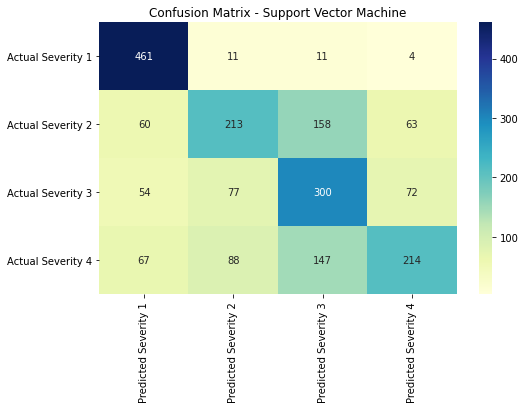

In [54]:
y_pred = svc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()

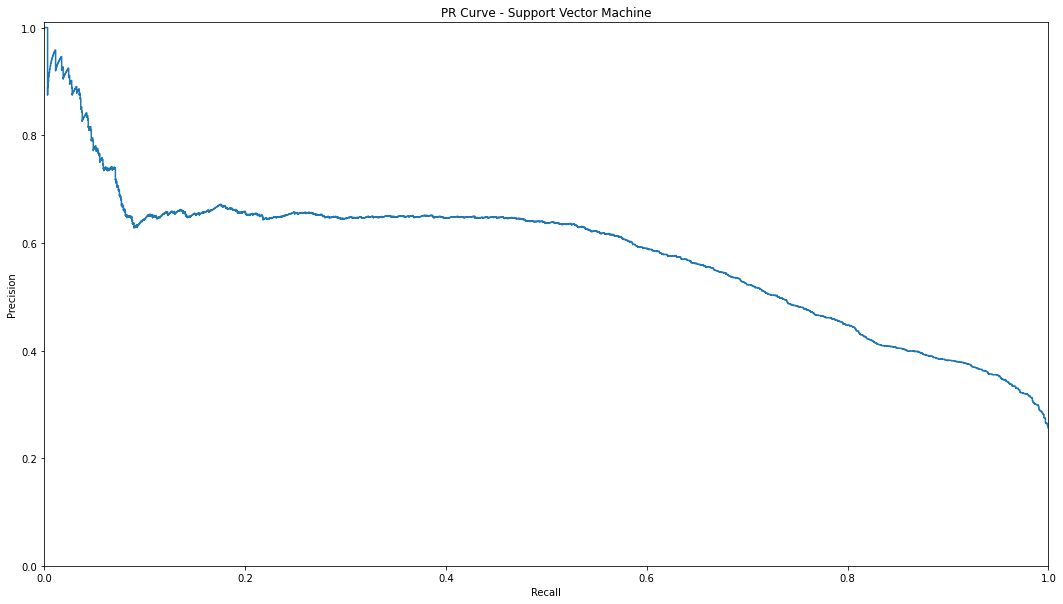

In [56]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = svc.decision_function(X_validate)

precision["SVM"], recall["SVM"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["SVM"], tpr["SVM"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["SVM"], precision["SVM"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Support Vector Machine")
plt.show()

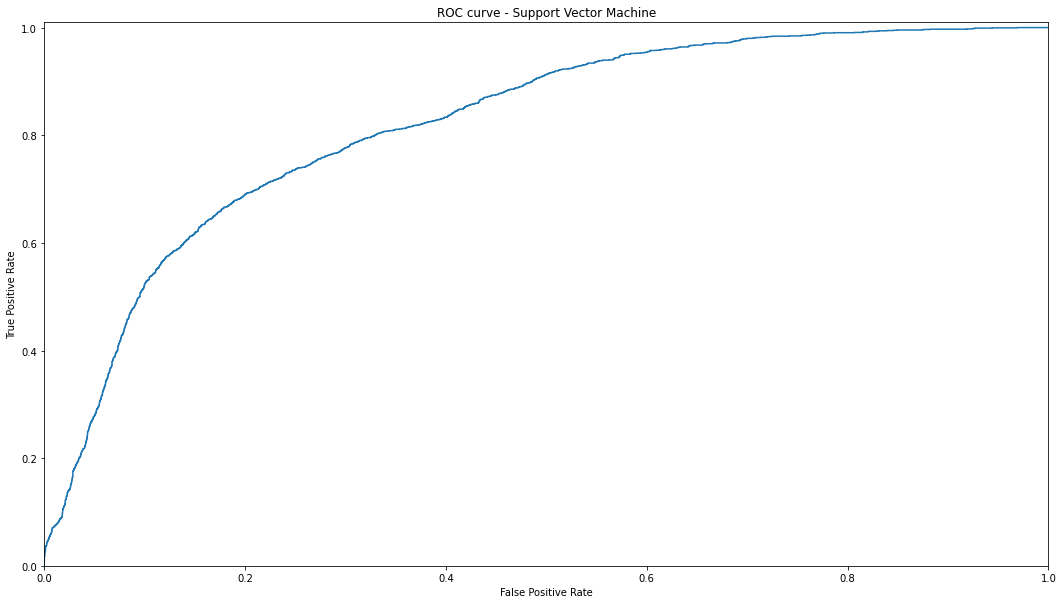

In [57]:
plt.figure(figsize=(18, 10))
plt.step(fpr["SVM"], tpr["SVM"], where="post")

plt.title("ROC curve - Support Vector Machine")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [58]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62421, 61) (62421,)
(20807, 61) (20807,)


In [59]:
dtc = DecisionTreeClassifier(random_state=42)
parameters = [{"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(dtc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters scores:
{'criterion': 'gini', 'max_depth': 10}
Train score: 0.7673699556239086
Validation score: 0.74758494737348


In [61]:
print("Default scores:")
dtc.fit(X_train, y_train)
print("Train score:", dtc.score(X_train, y_train))
print("Validation score:", dtc.score(X_validate, y_validate))

Default scores:
Train score: 0.999935919001618
Validation score: 0.6800595953284952


In [62]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       1.786792      0.149996         0.035393        0.010308   
5       1.941963      0.090205         0.021594        0.002676   
2       2.615410      0.134570         0.032979        0.007298   
6       2.362449      0.138419         0.016998        0.003398   
0       0.907062      0.084154         0.025832        0.007438   
4       1.211399      0.101931         0.028004        0.006427   
7       2.046862      0.082801         0.015189        0.003786   
3       3.277622      0.241798         0.035212        0.012192   

  param_criterion param_max_depth                                     params  \
1            gini              10     {'criterion': 'gini', 'max_depth': 10}   
5         entropy              10  {'criterion': 'entropy', 'max_depth': 10}   
2            gini              15     {'criterion': 'gini', 'max_depth': 15}   
6         entropy              15  {'criterion': 'entropy', 'max_depth': 15}   
0            gini               5      {'criterion': 'gini', 'max_depth': 5}   
4         entropy               5   {'criterion': 'entropy', 'max_depth': 5}   
7         entropy              30  {'criterion': 'entropy', 'max_depth': 30}   
3            gini              30     {'criterion': 'gini', 'max_depth': 30}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.744654           0.739266           0.740948           0.743752   
5           0.740248           0.735341           0.734220           0.742150   
2           0.736564           0.725649           0.723086           0.717879   
6           0.728074           0.714034           0.722925           0.722124   
0           0.719904           0.713153           0.716677           0.714675   
4           0.718222           0.713073           0.716197           0.715476   
7           0.686103           0.674944           0.679029           0.683915   
3           0.685943           0.678709           0.674383           0.684476   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.745915         0.742907        0.002445                1  
5           0.745114         0.739415        0.004105                2  
2           0.730135         0.726662        0.006341                3  
6           0.727972         0.723026        0.005131                4  
0           0.721564         0.717194        0.003143                5  
4           0.721003         0.716794        0.002672                6  
7           0.688882         0.682575        0.004997                7  
3           0.683114         0.681325        0.004231                8

In [63]:
y_pred = dtc.predict(X_validate)

accuracy["Decision Tree"] = accuracy_score(y_validate, y_pred)
f1["Decision Tree"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, dtc.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     15612
           2       1.00      1.00      1.00     15561
           3       1.00      1.00      1.00     15522
           4       1.00      1.00      1.00     15726

    accuracy                           1.00     62421
   macro avg       1.00      1.00      1.00     62421
weighted avg       1.00      1.00      1.00     62421

              precision    recall  f1-score   support

           1       0.88      0.88      0.88      5220
           2       0.57      0.57      0.57      5173
           3       0.56      0.56      0.56      5264
           4       0.71      0.71      0.71      5150

    accuracy                           0.68     20807
   macro avg       0.68      0.68      0.68     20807
weighted avg       0.68      0.68      0.68     20807



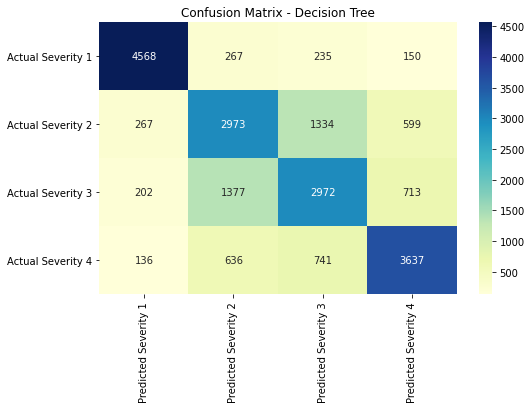

In [64]:
y_pred = dtc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

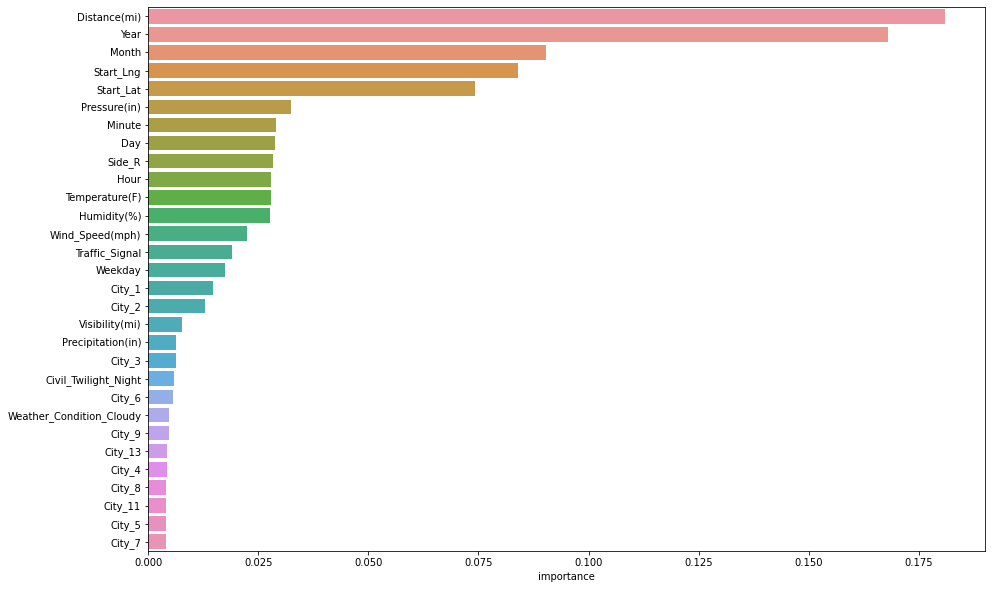

In [65]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = dtc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

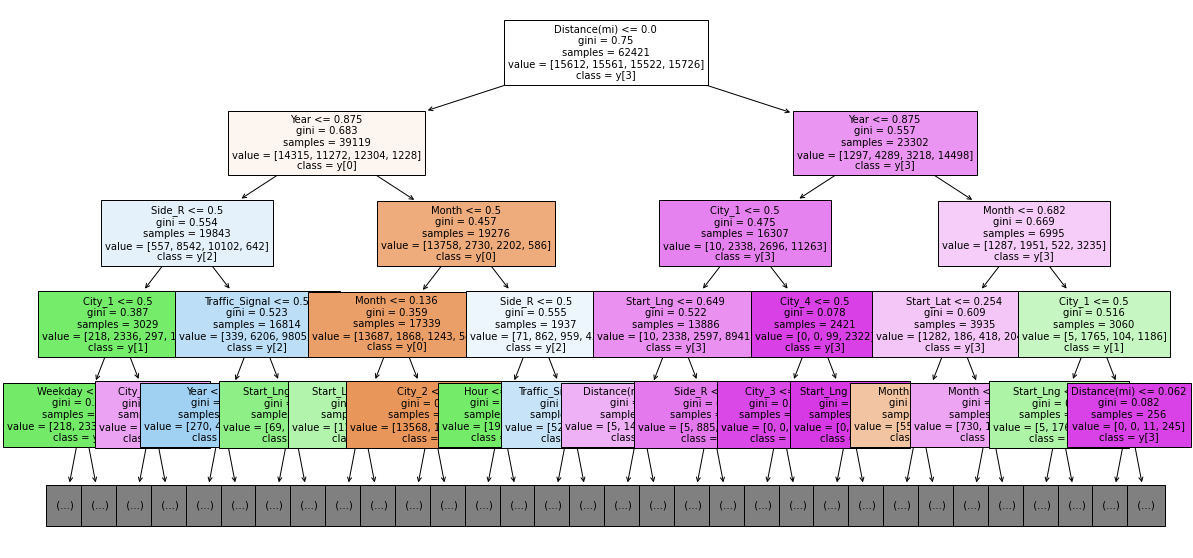

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train.columns.to_list(), class_names = True, filled=True)
plt.show()

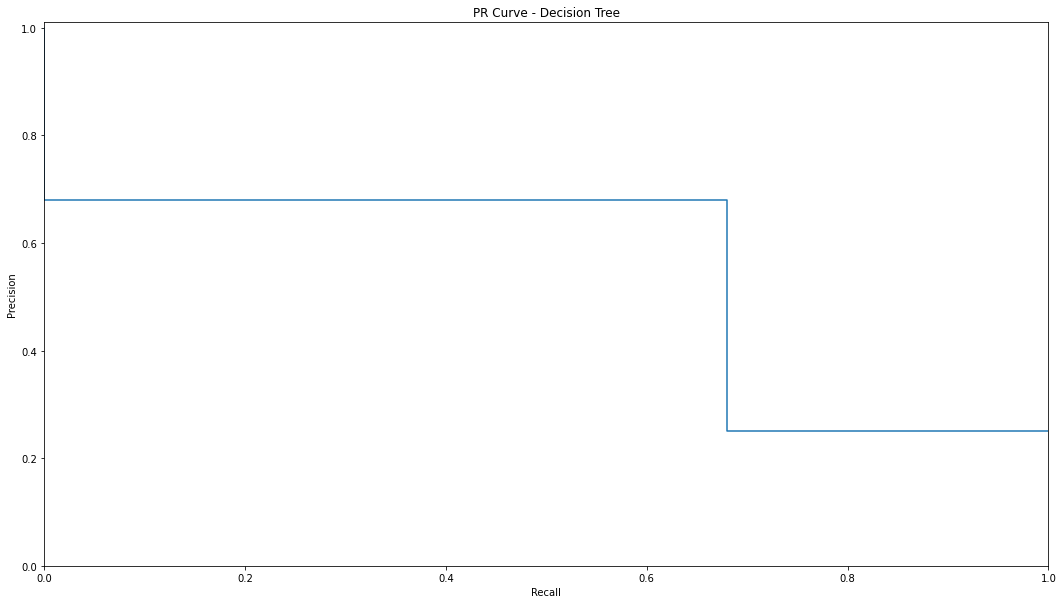

In [67]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = dtc.predict_proba(X_validate)

precision["Decision Tree"], recall["Decision Tree"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Decision Tree"], tpr["Decision Tree"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Decision Tree"], precision["Decision Tree"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Decision Tree")
plt.show()

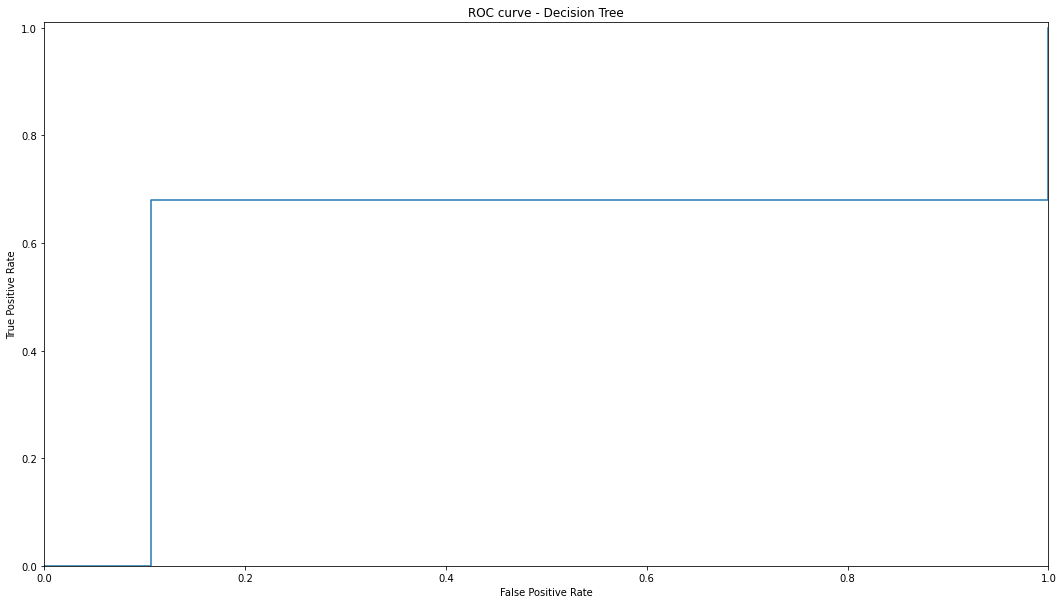

In [68]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Decision Tree"], tpr["Decision Tree"], where="post")

plt.title("ROC curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [69]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62421, 61) (62421,)
(20807, 61) (20807,)


In [70]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
parameters = [{"n_estimators": [50, 100, 200, 500], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(rfc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters scores:
{'max_depth': 30, 'n_estimators': 500}
Train score: 0.9998397975040451
Validation score: 0.773249387225453


In [71]:
print("Default scores:")
rfc.fit(X_train, y_train)
print("Train score:", rfc.score(X_train, y_train))
print("Validation score:", rfc.score(X_validate, y_validate))

Default scores:
Train score: 0.9999198987520226
Validation score: 0.7724804152448695


In [72]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15      78.239568      0.766454         3.184688        1.362628   
14      43.252178      1.861235         9.052799        1.821389   
13      32.082438      0.960476         9.179263        1.814471   
12      21.724678      1.187221         9.497212        0.477253   
10      38.449715      2.509106        10.256384        1.416957   
11      92.711438      0.635086         6.622298        0.243353   
9       27.609031      0.969570         5.775571        2.141521   
8       18.585156      3.100261         8.751661        0.806951   
6       30.233746      4.478292         9.012090        2.831243   
7       73.065239      0.268677         3.791663        0.184478   
5       19.111034      0.651266         3.050776        0.514368   
4       12.353229      1.489765         6.660206        1.551532   
2       11.022011      0.493499         5.803203        2.455595   
1        8.415755      0.395415         2.117803        0.175863   
3       35.660149      1.924249         5.236724        1.659912   
0        2.735067      0.651615         4.591084        1.344592   

   param_max_depth param_n_estimators                                  params  \
15              30                500  {'max_depth': 30, 'n_estimators': 500}   
14              30                200  {'max_depth': 30, 'n_estimators': 200}   
13              30                100  {'max_depth': 30, 'n_estimators': 100}   
12              30                 50   {'max_depth': 30, 'n_estimators': 50}   
10              15                200  {'max_depth': 15, 'n_estimators': 200}   
11              15                500  {'max_depth': 15, 'n_estimators': 500}   
9               15                100  {'max_depth': 15, 'n_estimators': 100}   
8               15                 50   {'max_depth': 15, 'n_estimators': 50}   
6               10                200  {'max_depth': 10, 'n_estimators': 200}   
7               10                500  {'max_depth': 10, 'n_estimators': 500}   
5               10                100  {'max_depth': 10, 'n_estimators': 100}   
4               10                 50   {'max_depth': 10, 'n_estimators': 50}   
2                5                200   {'max_depth': 5, 'n_estimators': 200}   
1                5                100   {'max_depth': 5, 'n_estimators': 100}   
3                5                500   {'max_depth': 5, 'n_estimators': 500}   
0                5                 50    {'max_depth': 5, 'n_estimators': 50}   

    split0_test_score  split1_test_score  split2_test_score  \
15           0.767241           0.767142           0.759773   
14           0.768202           0.763698           0.760173   
13           0.766360           0.762897           0.756729   
12           0.759632           0.761054           0.752884   
10           0.755627           0.753284           0.752563   
11           0.755787           0.753284           0.751121   
9            0.753624           0.753204           0.752083   
8            0.751061           0.747757           0.750801   
6            0.739287           0.732858           0.733098   
7            0.738326           0.732698           0.733339   
5            0.736964           0.732057           0.732137   
4            0.732799           0.729334           0.731416   
2            0.704766           0.700577           0.700096   
1            0.703885           0.698814           0.696892   
3            0.704926           0.698814           0.697453   
0            0.700120           0.694970           0.695130   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
15           0.766181           0.768103         0.765688        0.003020   
14           0.764899           0.768183         0.765031        0.003013   
13           0.763617           0.765540         0.763028        0.003390   
12           0.758571           0.762336         0.758895        0.003264   
10          

In [73]:
y_pred = rfc.predict(X_validate)

accuracy["Random Forest"] = accuracy_score(y_validate, y_pred)
f1["Random Forest"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, rfc.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     15612
           2       1.00      1.00      1.00     15561
           3       1.00      1.00      1.00     15522
           4       1.00      1.00      1.00     15726

    accuracy                           1.00     62421
   macro avg       1.00      1.00      1.00     62421
weighted avg       1.00      1.00      1.00     62421

              precision    recall  f1-score   support

           1       0.90      0.94      0.92      5220
           2       0.73      0.61      0.66      5173
           3       0.71      0.65      0.68      5264
           4       0.74      0.88      0.80      5150

    accuracy                           0.77     20807
   macro avg       0.77      0.77      0.77     20807
weighted avg       0.77      0.77      0.77     20807



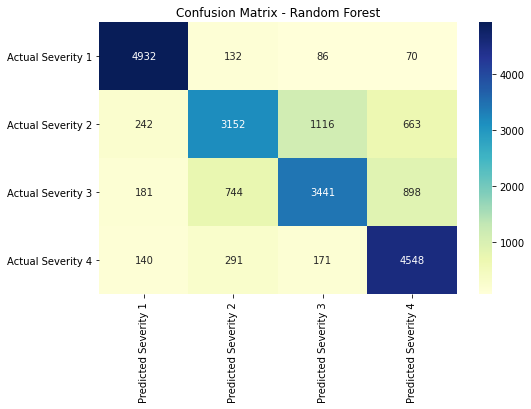

In [74]:
y_pred = rfc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest")
plt.show()

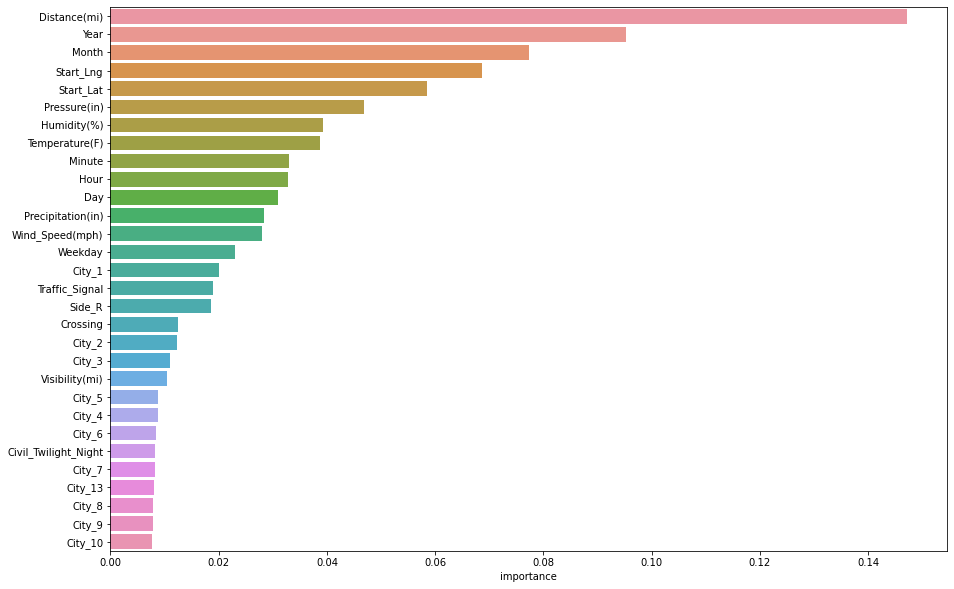

In [75]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

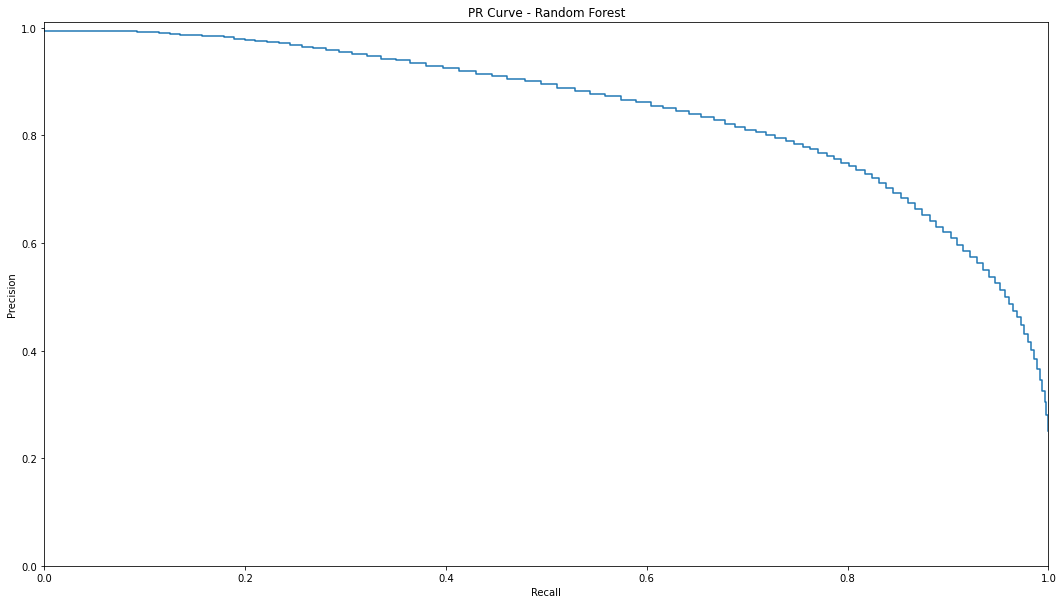

In [76]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_validate)

precision["Random Forest"], recall["Random Forest"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Random Forest"], precision["Random Forest"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Random Forest")
plt.show()

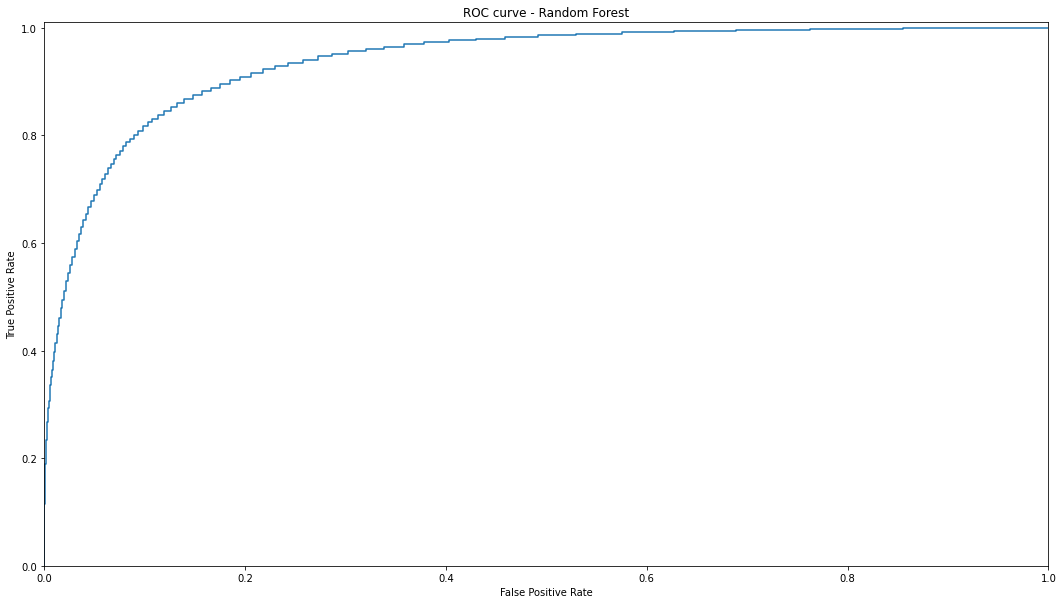

In [77]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Random Forest"], tpr["Random Forest"], where="post")

plt.title("ROC curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [78]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62421, 61) (62421,)
(20807, 61) (20807,)


In [79]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print("Train score:", gnb.score(X_train, y_train))
print("Validation score:", gnb.score(X_validate, y_validate))

Train score: 0.44092532961663544
Validation score: 0.43451722977843993


In [80]:
y_pred = gnb.predict(X_validate)

accuracy["Gaussian Naive Bayes"] = accuracy_score(y_validate, y_pred)
f1["Gaussian Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, gnb.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.40      0.96      0.57     15612
           2       0.45      0.25      0.33     15561
           3       0.42      0.34      0.37     15522
           4       0.80      0.21      0.34     15726

    accuracy                           0.44     62421
   macro avg       0.52      0.44      0.40     62421
weighted avg       0.52      0.44      0.40     62421

              precision    recall  f1-score   support

           1       0.40      0.95      0.57      5220
           2       0.43      0.24      0.31      5173
           3       0.42      0.33      0.37      5264
           4       0.80      0.21      0.33      5150

    accuracy                           0.43     20807
   macro avg       0.51      0.43      0.39     20807
weighted avg       0.51      0.43      0.39     20807



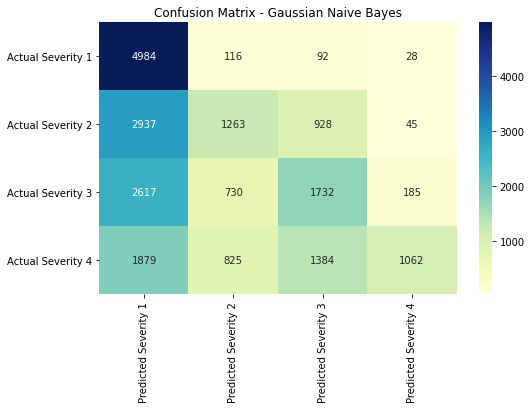

In [81]:
y_pred = gnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

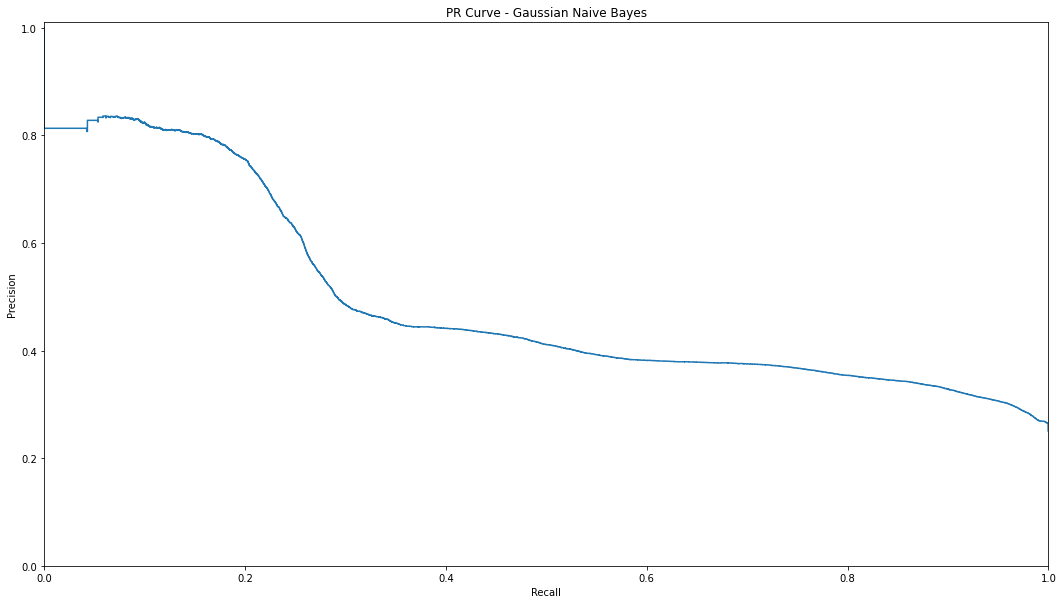

In [82]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = gnb.predict_proba(X_validate)

precision["Gaussian Naive Bayes"], recall["Gaussian Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Gaussian Naive Bayes"], precision["Gaussian Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Gaussian Naive Bayes")
plt.show()

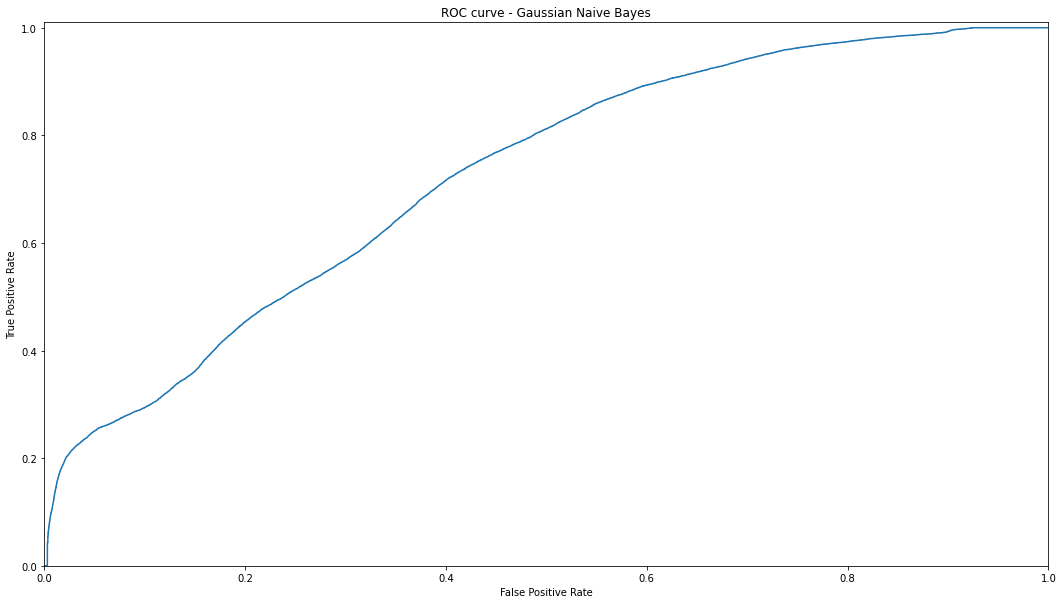

In [83]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], where="post")

plt.title("ROC curve - Gaussian Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [84]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

print("Train score:", mnb.score(X_train, y_train))
print("Validation score:", mnb.score(X_validate, y_validate))

Train score: 0.48611845372550905
Validation score: 0.48512519825058875


In [85]:
y_pred = mnb.predict(X_validate)

accuracy["Multinomial Naive Bayes"] = accuracy_score(y_validate, y_pred)
f1["Multinomial Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, mnb.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64     15612
           2       0.46      0.19      0.27     15561
           3       0.38      0.63      0.48     15522
           4       0.54      0.44      0.48     15726

    accuracy                           0.49     62421
   macro avg       0.50      0.49      0.47     62421
weighted avg       0.50      0.49      0.47     62421

              precision    recall  f1-score   support

           1       0.61      0.68      0.64      5220
           2       0.47      0.19      0.27      5173
           3       0.38      0.63      0.48      5264
           4       0.53      0.43      0.48      5150

    accuracy                           0.49     20807
   macro avg       0.50      0.48      0.47     20807
weighted avg       0.50      0.49      0.47     20807



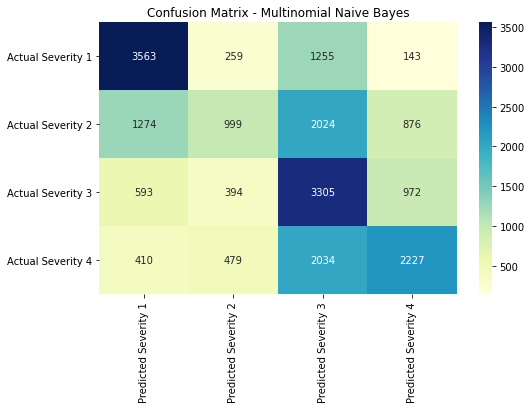

In [86]:
y_pred = mnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

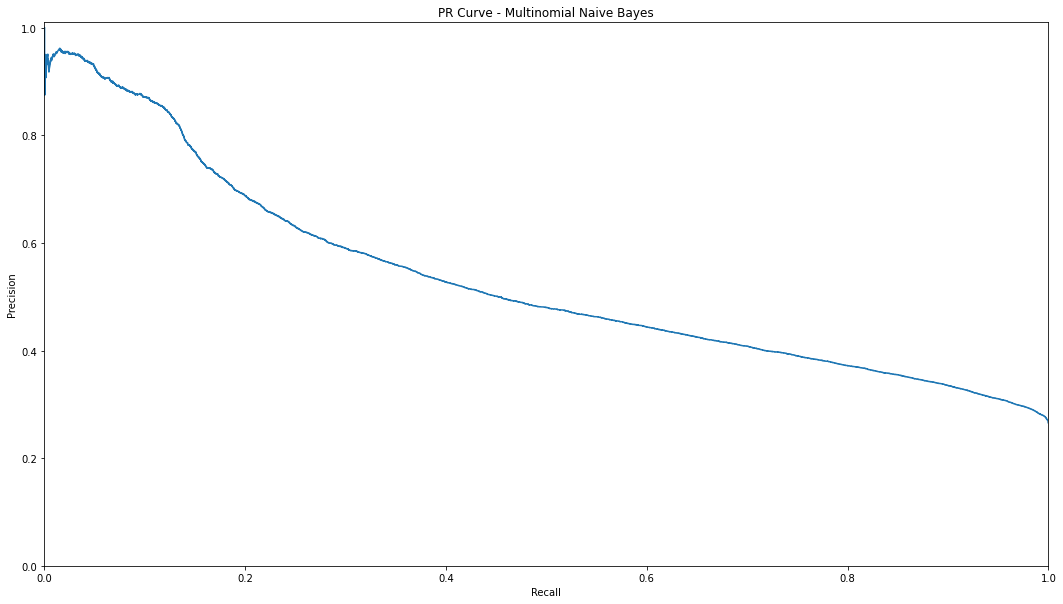

In [88]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = mnb.predict_proba(X_validate)

precision["Multinomial Naive Bayes"], recall["Multinomial Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multinomial Naive Bayes"], precision["Multinomial Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multinomial Naive Bayes")
plt.show()

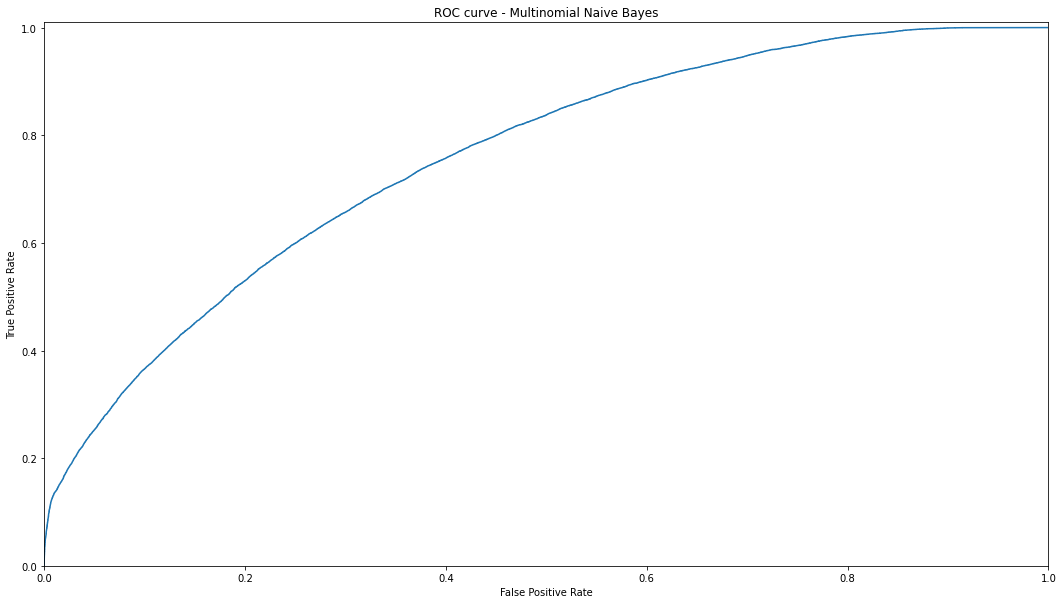

In [89]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], where="post")

plt.title("ROC curve - Multinomial Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [90]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

print("Train score:", bnb.score(X_train, y_train))
print("Validation score:", bnb.score(X_validate, y_validate))

Train score: 0.586228993447718
Validation score: 0.5875907146633345


In [91]:
y_pred = bnb.predict(X_validate)

accuracy["Bernoulli Naive Bayes"] = accuracy_score(y_validate, y_pred)
f1["Bernoulli Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, mnb.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64     15612
           2       0.46      0.19      0.27     15561
           3       0.38      0.63      0.48     15522
           4       0.54      0.44      0.48     15726

    accuracy                           0.49     62421
   macro avg       0.50      0.49      0.47     62421
weighted avg       0.50      0.49      0.47     62421

              precision    recall  f1-score   support

           1       0.65      0.73      0.68      5220
           2       0.55      0.26      0.36      5173
           3       0.53      0.56      0.54      5264
           4       0.60      0.80      0.69      5150

    accuracy                           0.59     20807
   macro avg       0.58      0.59      0.57     20807
weighted avg       0.58      0.59      0.57     20807



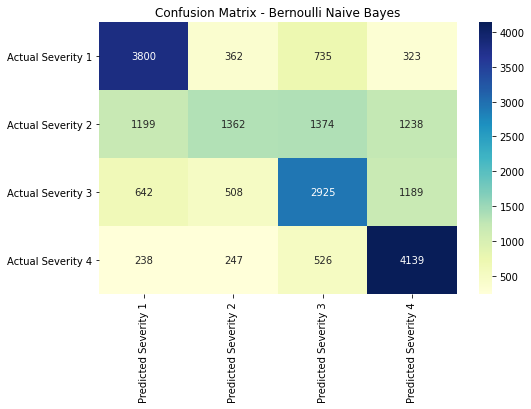

In [92]:
y_pred = bnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Bernoulli Naive Bayes")
plt.show()

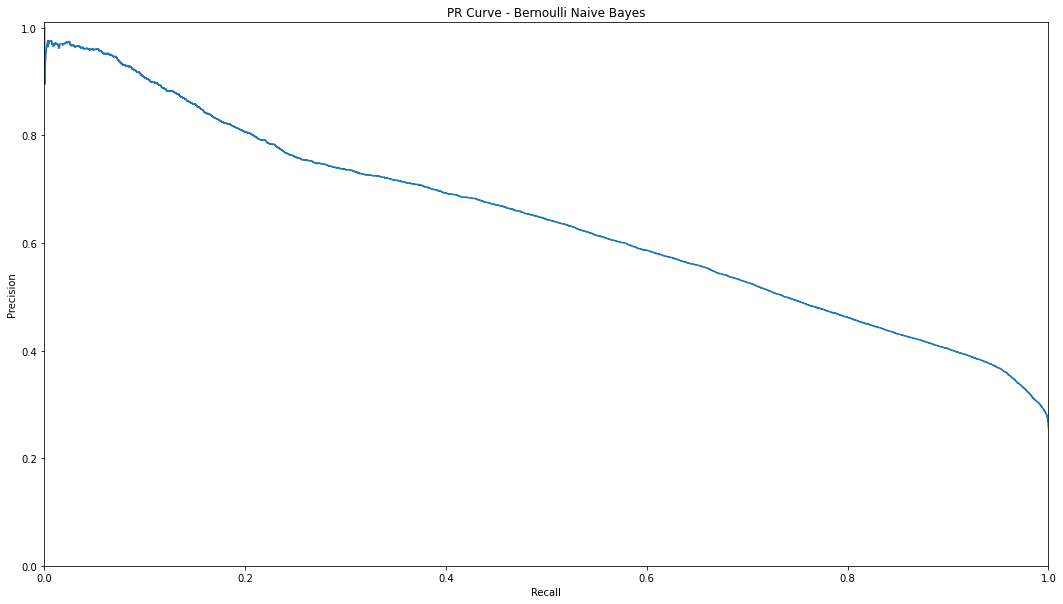

In [93]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = bnb.predict_proba(X_validate)

precision["Bernoulli Naive Bayes"], recall["Bernoulli Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Bernoulli Naive Bayes"], precision["Bernoulli Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Bernoulli Naive Bayes")
plt.show()

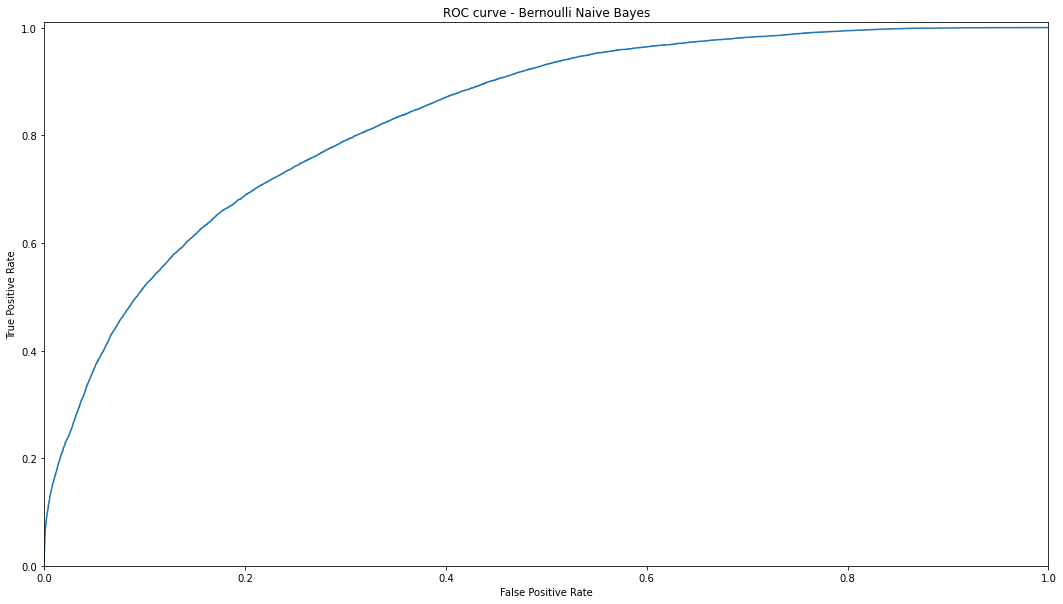

In [94]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], where="post")

plt.title("ROC curve - Bernoulli Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [95]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62421, 61) (62421,)
(20807, 61) (20807,)


In [96]:
mlp = MLPClassifier(random_state=42, verbose=False)
parameters = [{"hidden_layer_sizes": [(64, 32), (32, 64, 32)], "max_iter": [200], "solver": ["sgd", "adam"], "activation": ["tanh", "relu"]}]
grid = GridSearchCV(mlp, parameters, verbose=5, n_jobs=-1)

sample = X.sample(10_000, random_state=42)
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)
grid.fit(X_sample, y_sample)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Best parameters scores:
{'activation': 'tanh', 'hidden_layer_sizes': (64, 32), 'max_iter': 200, 'solver': 'adam'}
Train score: 0.6299482545938065
Validation score: 0.6969289181525448


In [97]:
print("Default scores:")
mlp.fit(X_train, y_train)
print("Train score:", mlp.score(X_train, y_train))
print("Validation score:", mlp.score(X_validate, y_validate))

Default scores:
Train score: 0.7582864741032666
Validation score: 0.7217763252751478


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [98]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      37.723174      1.954274         0.026131        0.002985   
3      39.951086      1.881197         0.028921        0.002602   
6      31.893406      0.893861         0.014561        0.002053   
2      36.849843      2.345363         0.029520        0.009723   
0      33.862852      1.817197         0.034109        0.007118   
4      30.303472      1.496978         0.020545        0.003375   
7      20.922506      5.336060         0.006787        0.000741   
5      30.745061      1.423664         0.024336        0.010318   

  param_activation param_hidden_layer_sizes param_max_iter param_solver  \
1             tanh                 (64, 32)            200         adam   
3             tanh             (32, 64, 32)            200         adam   
6             relu             (32, 64, 32)            200          sgd   
2             tanh             (32, 64, 32)            200          sgd   
0             tanh                 (64, 32)            200          sgd   
4             relu                 (64, 32)            200          sgd   
7             relu             (32, 64, 32)            200         adam   
5             relu                 (64, 32)            200         adam   

                                              params  split0_test_score  \
1  {'activation': 'tanh', 'hidden_layer_sizes': (...             0.6175   
3  {'activation': 'tanh', 'hidden_layer_sizes': (...             0.6120   
6  {'activation': 'relu', 'hidden_layer_sizes': (...             0.5975   
2  {'activation': 'tanh', 'hidden_layer_sizes': (...             0.5890   
0  {'activation': 'tanh', 'hidden_layer_sizes': (...             0.5855   
4  {'activation': 'relu', 'hidden_layer_sizes': (...             0.5830   
7  {'activation': 'relu', 'hidden_layer_sizes': (...             0.5810   
5  {'activation': 'relu', 'hidden_layer_sizes': (...             0.5735   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
1             0.6425             0.6305             0.6245             0.5930   
3             0.6285             0.6230             0.6110             0.6210   
6             0.6210             0.6090             0.5890             0.5880   
2             0.6165             0.6000             0.5945             0.5980   
0             0.6160             0.6020             0.5890             0.5945   
4             0.6150             0.5955             0.5900             0.5810   
7             0.6005             0.5880             0.5880             0.5895   
5             0.6125             0.5905             0.5860             0.5770   

   mean_test_score  std_test_score  rank_test_score  
1           0.6216        0.016488                1  
3           0.6191        0.006681                2  
6           0.6009        0.012563                3  
2           0.5996        0.009238                4  
0           0.5974        0.010842                5  
4           0.5929        0.012192                6  
7           0.5894        0.006288                7  
5           0.5879        0.013724                8

In [99]:
y_pred = mlp.predict(X_validate)

accuracy["Multi Layer Perceptron"] = accuracy_score(y_validate, y_pred)
f1["Multi Layer Perceptron"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, mlp.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.93      0.91     15612
           2       0.67      0.67      0.67     15561
           3       0.71      0.60      0.65     15522
           4       0.75      0.83      0.78     15726

    accuracy                           0.76     62421
   macro avg       0.76      0.76      0.75     62421
weighted avg       0.76      0.76      0.76     62421

              precision    recall  f1-score   support

           1       0.88      0.92      0.90      5220
           2       0.62      0.62      0.62      5173
           3       0.66      0.57      0.61      5264
           4       0.72      0.78      0.75      5150

    accuracy                           0.72     20807
   macro avg       0.72      0.72      0.72     20807
weighted avg       0.72      0.72      0.72     20807



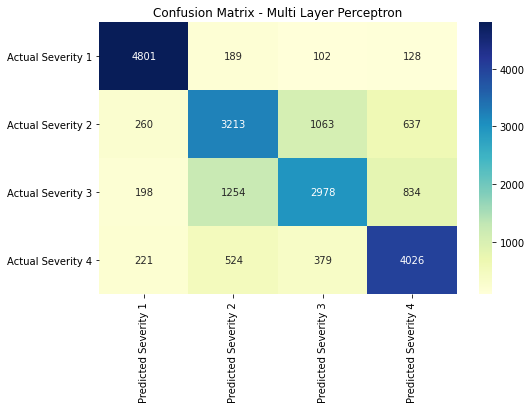

In [100]:
y_pred = mlp.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multi Layer Perceptron")
plt.show()

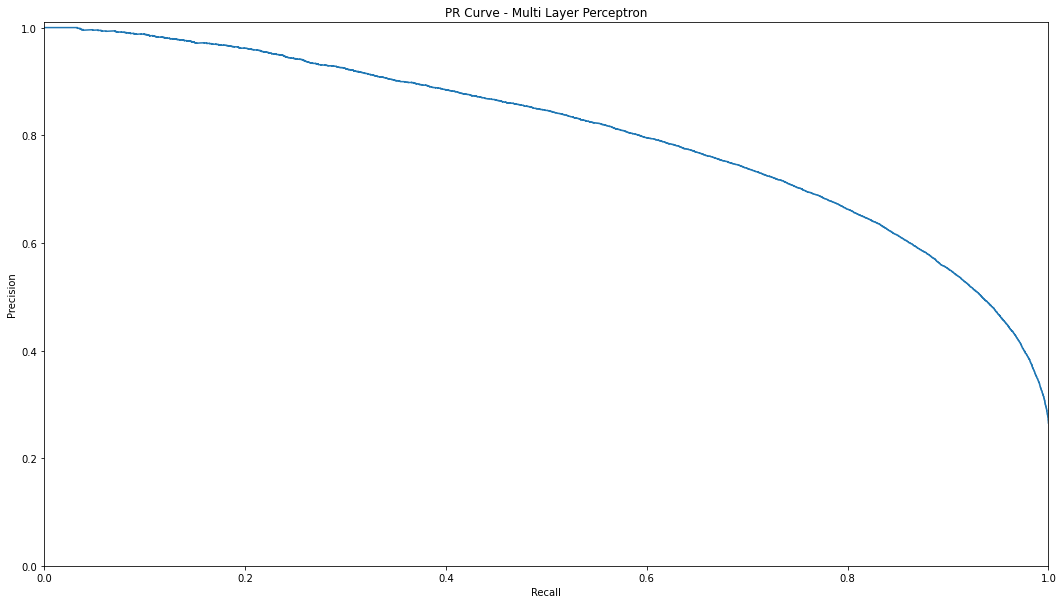

In [101]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = mlp.predict_proba(X_validate)

precision["Multi Layer Perceptron"], recall["Multi Layer Perceptron"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multi Layer Perceptron"], tpr["Multi Layer Perceptron"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multi Layer Perceptron"], precision["Multi Layer Perceptron"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multi Layer Perceptron")
plt.show()

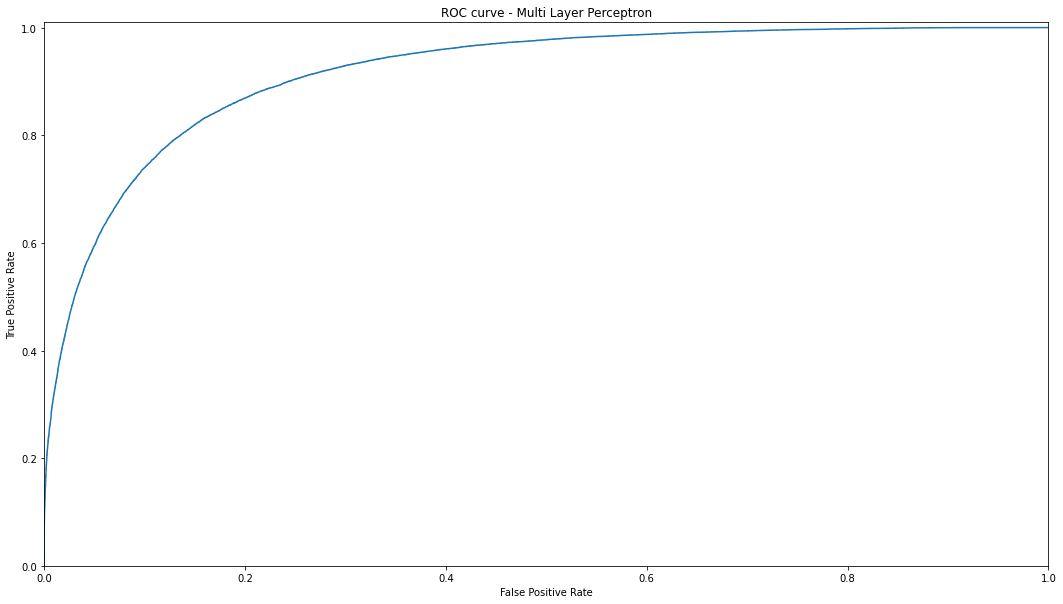

In [102]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multi Layer Perceptron"], tpr["Multi Layer Perceptron"], where="post")

plt.title("ROC curve - Multi Layer Perceptron")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



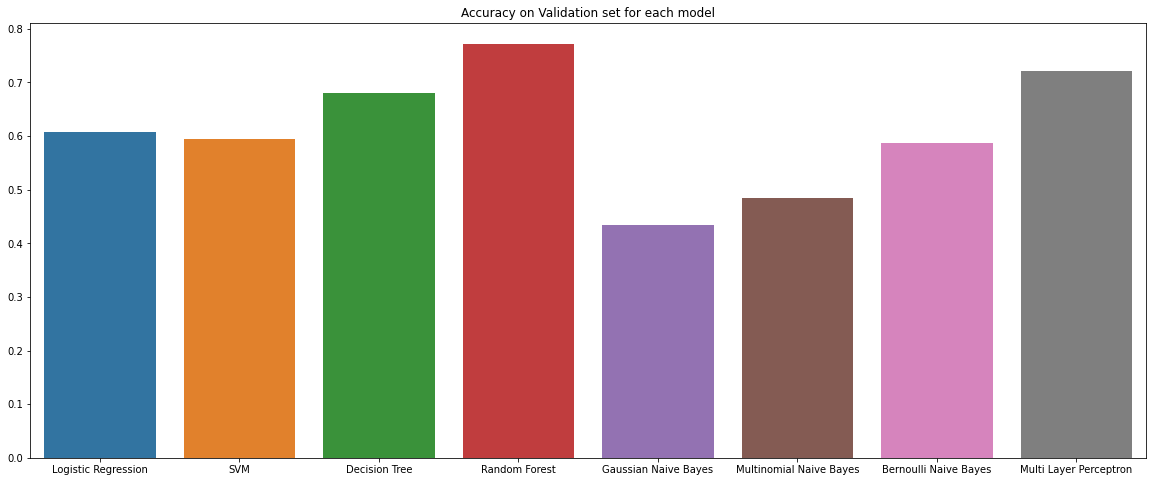

In [103]:
plt.figure(figsize=(20, 8))
plt.title("Accuracy on Validation set for each model")
sns.barplot(list(range(len(accuracy))), list(accuracy.values()))
plt.xticks(range(len(accuracy)), labels=accuracy.keys())
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



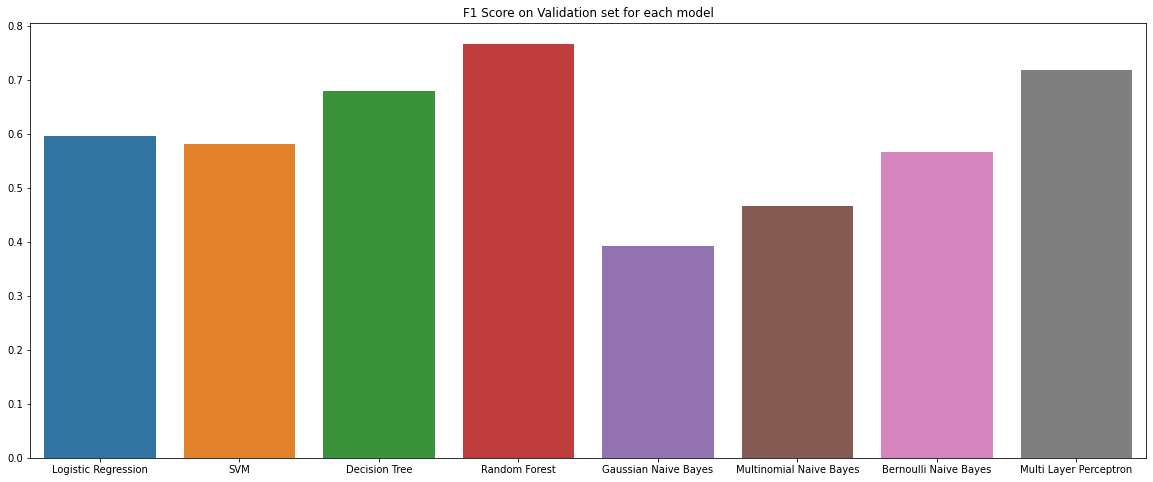

In [104]:
plt.figure(figsize=(20, 8))
plt.title("F1 Score on Validation set for each model")
sns.barplot(list(range(len(f1))), list(f1.values()))
plt.xticks(range(len(f1)), labels=f1.keys())
plt.show()

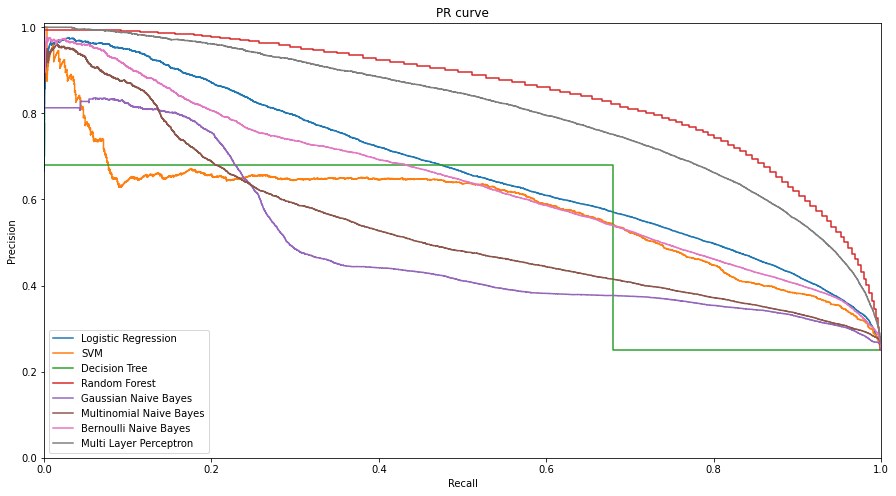

In [105]:
plt.figure(figsize=(15, 8))
for key in f1.keys():
    plt.step(recall[key], precision[key], where="post", label=key)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR curve")
plt.legend()
plt.show()

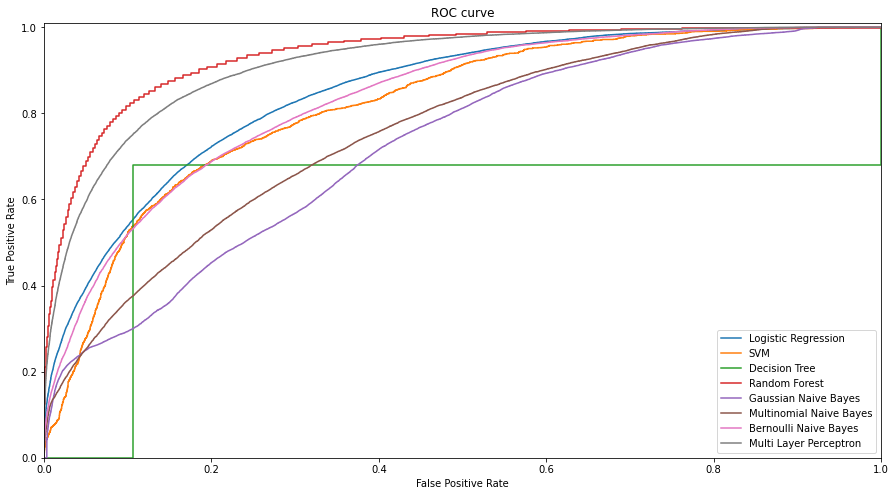

In [106]:
plt.figure(figsize=(15, 8))
for key in f1.keys():
    plt.step(fpr[key], tpr[key], where="post", label=key)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("ROC curve")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           1       0.89      0.94      0.91      5177
           2       0.73      0.60      0.66      5275
           3       0.70      0.64      0.67      5223
           4       0.72      0.88      0.79      5133

    accuracy                           0.76     20808
   macro avg       0.76      0.76      0.76     20808
weighted avg       0.76      0.76      0.76     20808



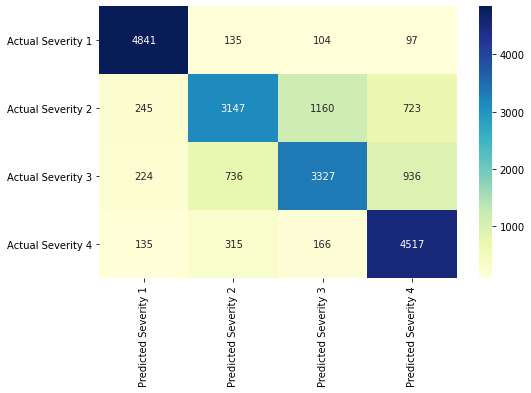

In [107]:
sample = X_test
y_test_sample = sample["Severity"]
X_test_sample = sample.drop("Severity", axis=1)

y_pred = rfc.predict(X_test_sample)

print(classification_report(y_test_sample, y_pred))

confmat = confusion_matrix(y_true=y_test_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.show()